# Consensus Docking Results Analysis

This notebook analyzes large-scale consensus docking results to evaluate binding pose consistency and perform cluster-based selectivity analysis.

## 🚀 Quick Start Guide

**For most users:** Simply run cells 2-4 to load, filter, and start analysis immediately.

**First-time users or data updates:** If you need to create/update the data files, run the optimized data preparation script:
```bash
python parse_prepare.py
```
This high-performance script uses multiprocessing to efficiently process millions of docking results in minutes instead of hours.

## 📊 Analysis Overview

### Main Analysis Workflow
1. **Data Loading** (Step 1) - Smart loading of existing data files
2. **Cluster Integration** (Step 2) - Add cavity similarity information  
3. **Tool Coverage Filtering** (Step 2.5) - **NEW:** Filter for complete tool coverage
4. **Data Quality Check** (Step 3) - Dataset overview of filtered data
5. **Tool Reliability Analysis** (Step 4) - Consensus analysis between tools
6. **Cluster Analysis** - Binding site similarity and drug selectivity
7. **Visualizations** - Comprehensive plots and insights

### Key Outputs
- **Fair tool comparisons** using only drug-target pairs with complete tool coverage
- Pose consistency metrics across docking tools
- Drug-target binding success rates
- Cluster-based selectivity patterns
- Tool agreement analysis

---

## 📥 Step 1: Smart Data Loading

This cell automatically detects and loads the best available data source. Run this first!

In [1]:
# =============================================================================
# 📥 SMART DATA LOADING - START HERE
# =============================================================================

import os, re
import polars as pl
from pathlib import Path

# Configuration
PARQUET_FILE = "combined_consensus_docking_results.parquet"
CSV_FILE = "combined_consensus_docking_results.csv"
BASE_FOLDER = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/consensus_docking_results"

print("🔍 Checking for existing data files...")

# Smart data loading: try parquet first, then CSV, then create from scratch
combined_results = None

if os.path.exists(PARQUET_FILE):
    print(f"✅ Found Parquet file: {PARQUET_FILE}")
    print("📖 Loading data (this is the fastest option)...")
    combined_results = pl.read_parquet(PARQUET_FILE)
    print(f"   Shape: {combined_results.shape}")
    print(f"   Memory: {combined_results.estimated_size() / (1024*1024):.1f} MB")
    print("✅ Data loaded successfully!")

elif os.path.exists(CSV_FILE):
    print(f"✅ Found CSV file: {CSV_FILE}")
    print("📖 Loading data (slower than Parquet but still good)...")
    combined_results = pl.read_csv(CSV_FILE)
    print(f"   Shape: {combined_results.shape}")
    print(f"   Memory: {combined_results.estimated_size() / (1024*1024):.1f} MB")
    print("✅ Data loaded successfully!")

else:
    print("❌ No preprocessed data files found!")
    print(f"   Looking for: {PARQUET_FILE} or {CSV_FILE}")
    print("\n� To create the data files, run the optimized preparation script:")
    print("   ```bash")
    print("   python parse_prepare.py")
    print("   ```")
    print("\n⚡ This high-performance script features:")
    print("   • Multiprocessing across all CPU cores")
    print("   • Progress bars for visual feedback")
    print("   • Processing rate: ~25,000 records/second")
    print("   • Creates both CSV and Parquet formats")
    print("   • Typical runtime: 5-10 minutes for millions of records")
    combined_results = pl.DataFrame()  # Empty dataframe

# Quick validation
if not combined_results.is_empty():
    print(f"\n📊 Dataset Overview:")
    print(f"   Total rows: {combined_results.height:,}")
    print(f"   Columns: {combined_results.width}")
    print(f"   Key columns: {combined_results.columns}")
    
    # Check for required columns
    required_cols = ['drugbank_id', 'uniprot_id', 'RMSD', 'Score1', 'Score2']
    missing_cols = [col for col in required_cols if col not in combined_results.columns]
    if missing_cols:
        print(f"⚠️  Missing columns: {missing_cols}")
    else:
        print("✅ All required columns present")
else:
    print("\n⚠️  No data available for analysis")
    print("   Please run: python parse_prepare.py")

🔍 Checking for existing data files...
✅ Found Parquet file: combined_consensus_docking_results.parquet
📖 Loading data (this is the fastest option)...
   Shape: (7844729, 30)
   Memory: 2862.2 MB
✅ Data loaded successfully!

📊 Dataset Overview:
   Total rows: 7,844,729
   Columns: 30
   Key columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'source_file', 'source_dir', 'file_size_mb', 'source_type', 'drugbank_id', 'uniprot_id', 'gene_name', 'cavity_index', 'Pose', 'SMINA_Score', 'Score', 'S(PLP)', 'S(hbond)', 'S(cho)', 'S(metal)', 'DE(clash)', 'DE(tors)', 'time', 'LeDock_Score', 'primary_tool', 'compound_target_pair']
✅ All required columns present


## 🧬 Step 2: Cluster Integration

Add cavity cluster information for advanced analysis (run once per session).

In [2]:
# =============================================================================
# 🗃️ STEP 2: CAVITY CLUSTER INTEGRATION
# =============================================================================

print("🗃️ CAVITY CLUSTER INTEGRATION")
print("=" * 50)

if not combined_results.is_empty():
    # Check if we already have cluster information
    if 'cavity_cluster_id' in combined_results.columns:
        non_null_clusters = combined_results['cavity_cluster_id'].drop_nulls().len()
        if non_null_clusters > 0:
            print(f"✅ Cluster data already present: {non_null_clusters:,} mapped entries")
            print("   Skipping cluster integration...")
        else:
            print("⚠️  Cluster column exists but empty - proceeding with integration...")
    
    # Proceed with cluster integration if needed
    if 'cavity_cluster_id' not in combined_results.columns or combined_results['cavity_cluster_id'].drop_nulls().len() == 0:
        try:
            print(f"📖 Loading cavity cluster data...")
            cluster_file = "/opt/data/cavity_space/cavity_cluster_similarity07.csv"
            clusters_df = pl.read_csv(cluster_file, separator='\t')
            print(f"📖 Loaded {clusters_df.height:,} clusters from CavitySpace")
            
            # Extract uniprot_id and cavity_index from source_dir if not already present
            print(f"� Extracting cavity identifiers from source paths...")
            
            combined_results = combined_results.with_columns([
                # Extract drugbank_id (1st component: DB00390_ATP1A1_Q13286_cavity_3)
                pl.col('source_dir').str.split('/').list.last()
                .str.extract(r'(DB\d+)_[A-Z0-9]+_[A-Z0-9]+_cavity_\d+', group_index=1)
                .alias('extracted_drugbank_id'),
                
                # Extract gene_name (2nd component: DB00390_ATP1A1_Q13286_cavity_3)
                pl.col('source_dir').str.split('/').list.last()
                .str.extract(r'DB\d+_([A-Z0-9]+)_[A-Z0-9]+_cavity_\d+', group_index=1)
                .alias('extracted_gene_name'),
                
                # Extract uniprot_id (3rd component: DB00390_ATP1A1_Q13286_cavity_3)
                pl.col('source_dir').str.split('/').list.last()
                .str.extract(r'DB\d+_[A-Z0-9]+_([A-Z0-9]+)_cavity_\d+', group_index=1)
                .alias('extracted_uniprot_id'),
                
                # Extract cavity_index (number after 'cavity_')
                pl.col('source_dir').str.split('/').list.last()
                .str.extract(r'cavity_(\d+)', group_index=1)
                .cast(pl.Int64, strict=False)
                .alias('extracted_cavity_index')
            ])
            
            # Check extraction results
            non_null_uniprot = combined_results['extracted_uniprot_id'].drop_nulls().len()
            non_null_cavity = combined_results['extracted_cavity_index'].drop_nulls().len()
            
            print(f"✅ Extraction results:")
            print(f"   Extracted uniprot_id: {non_null_uniprot:,} non-null values")
            print(f"   Extracted cavity_index: {non_null_cavity:,} non-null values")
            
            # Show sample extracted data for debugging
            sample_data = combined_results.select(['source_dir', 'extracted_uniprot_id', 'extracted_cavity_index']).head(3)
            print(f"   Sample extracted data:")
            print(sample_data)
            
            if non_null_uniprot > 0 and non_null_cavity > 0:
                # Create mapping dictionary from the cluster file
                cavity_to_cluster = {}
                successful_parses = 0
                failed_parses = 0
                
                print(f"🔄 Processing cluster file to create mapping...")
                
                for i, row in enumerate(clusters_df.to_dicts()):
                    cluster_id = row['id']  # The cluster ID
                    cavity_items = row['items']  # Comma-separated cavity IDs
                    
                    # Split the cavity items and process each one
                    if cavity_items and isinstance(cavity_items, str):
                        cavity_ids = cavity_items.split(',')
                        
                        for cavity_id in cavity_ids:
                            cavity_id = cavity_id.strip()
                            
                            # Parse cavity format: AF-{UniProtID}-F{Fragment}-model_v1_C{CavityIndex}
                            match = re.match(r'AF-([A-Z0-9]+)-F\d+-model_v1_C(\d+)', cavity_id)
                            if match:
                                uniprot_id, cavity_index = match.groups()
                                key = (uniprot_id, int(cavity_index))
                                cavity_to_cluster[key] = cluster_id
                                successful_parses += 1
                            else:
                                failed_parses += 1
                                if failed_parses <= 5:  # Show first few failures
                                    print(f"   ⚠️ Failed to parse cavity ID: '{cavity_id}'")
                
                print(f"📊 Cluster parsing results:")
                print(f"   Successfully parsed: {successful_parses:,} cavity IDs")
                print(f"   Failed to parse: {failed_parses:,} cavity IDs")
                print(f"   Created mapping for {len(cavity_to_cluster):,} unique cavities")
                
                # Show sample mapping entries
                sample_keys = list(cavity_to_cluster.keys())[:5]
                print(f"   Sample mappings:")
                for key in sample_keys:
                    print(f"     {key} -> cluster {cavity_to_cluster[key]}")
                
                # Check what UniProt IDs we have in our data vs cluster file
                our_uniprots = set(combined_results.filter(pl.col('extracted_uniprot_id').is_not_null())['extracted_uniprot_id'].unique().to_list())
                cluster_uniprots = set(key[0] for key in cavity_to_cluster.keys())
                
                print(f"\n🔍 UniProt ID overlap analysis:")
                print(f"   UniProts in our data: {len(our_uniprots):,}")
                print(f"   UniProts in cluster file: {len(cluster_uniprots):,}")
                print(f"   Overlap: {len(our_uniprots & cluster_uniprots):,}")
                
                # Show sample UniProts from each set
                print(f"   Sample from our data: {sorted(list(our_uniprots))[:5]}")
                print(f"   Sample from clusters: {sorted(list(cluster_uniprots))[:5]}")
                
                # Map clusters to our data
                def map_cluster(uniprot_id, cavity_index):
                    if cavity_index is None or uniprot_id is None:
                        return None
                    key = (uniprot_id, cavity_index)
                    return cavity_to_cluster.get(key)
                
                print(f"\n🔄 Applying cluster mapping...")
                
                combined_results = combined_results.with_columns([
                    pl.struct(['extracted_uniprot_id', 'extracted_cavity_index'])
                    .map_elements(lambda x: map_cluster(x['extracted_uniprot_id'], x['extracted_cavity_index']), return_dtype=pl.Int64)
                    .alias('cavity_cluster_id')
                ])
                
                # Report mapping results
                mapped_count = combined_results['cavity_cluster_id'].drop_nulls().len()
                total_count = len(combined_results)
                unique_clusters = combined_results['cavity_cluster_id'].n_unique()
                
                print(f"✅ Cluster mapping complete:")
                print(f"   Mapped: {mapped_count:,}/{total_count:,} ({mapped_count/total_count*100:.1f}%)")
                print(f"   Unique clusters: {unique_clusters:,}")
                
                if mapped_count > 0:
                    # Show sample mapped data
                    sample_mapped = combined_results.filter(pl.col('cavity_cluster_id').is_not_null()).select(['extracted_uniprot_id', 'extracted_cavity_index', 'cavity_cluster_id']).head(3)
                    print(f"   Sample mapped data:")
                    print(sample_mapped)
                    
                # Debug unmapped entries
                if mapped_count < total_count:
                    print(f"\n🔍 Debugging unmapped entries:")
                    unmapped = combined_results.filter(pl.col('cavity_cluster_id').is_null())
                    sample_unmapped = unmapped.select(['extracted_uniprot_id', 'extracted_cavity_index']).head(5)
                    print(f"   Sample unmapped entries:")
                    print(sample_unmapped)
                    
                    # Check if these should have mappings
                    for row in sample_unmapped.to_dicts():
                        uniprot_id = row['extracted_uniprot_id']
                        cavity_index = row['extracted_cavity_index']
                        key = (uniprot_id, cavity_index)
                        if key in cavity_to_cluster:
                            print(f"   ❗ Key {key} should map to cluster {cavity_to_cluster[key]} but doesn't!")
                        else:
                            print(f"   ✓ Key {key} correctly not in cluster mapping")
                
            else:
                print("❌ Extraction failed - adding empty cluster column...")
                combined_results = combined_results.with_columns([
                    pl.lit(None, dtype=pl.Int64).alias('cavity_cluster_id')
                ])
            
        except FileNotFoundError:
            print(f"⚠️  Cluster file not found: {cluster_file}")
            print("   Adding empty cluster column...")
            combined_results = combined_results.with_columns([
                pl.lit(None, dtype=pl.Int64).alias('cavity_cluster_id')
            ])
        except Exception as e:
            print(f"❌ Error loading clusters: {e}")
            print(f"   Error details: {type(e).__name__}: {str(e)}")
            combined_results = combined_results.with_columns([
                pl.lit(None, dtype=pl.Int64).alias('cavity_cluster_id')
            ])
    
    print(f"🎯 Ready for analysis with shape: {combined_results.shape}")
    
else:
    print("❌ No data available for cluster integration")
    print("   Please load data first (Step 1)")

🗃️ CAVITY CLUSTER INTEGRATION
📖 Loading cavity cluster data...
📖 Loaded 12,943 clusters from CavitySpace
� Extracting cavity identifiers from source paths...
✅ Extraction results:
   Extracted uniprot_id: 7,533,447 non-null values
   Extracted cavity_index: 7,698,728 non-null values
   Sample extracted data:
shape: (3, 3)
┌─────────────────────────────────┬──────────────────────┬────────────────────────┐
│ source_dir                      ┆ extracted_uniprot_id ┆ extracted_cavity_index │
│ ---                             ┆ ---                  ┆ ---                    │
│ str                             ┆ str                  ┆ i64                    │
╞═════════════════════════════════╪══════════════════════╪════════════════════════╡
│ /media/onur/Elements/cavity_sp… ┆ O94788               ┆ 1                      │
│ /media/onur/Elements/cavity_sp… ┆ O94788               ┆ 1                      │
│ /media/onur/Elements/cavity_sp… ┆ O94788               ┆ 1                      │
└───

## 🔍 Step 2.5: Filter for Complete Tool Coverage

**Important:** To ensure fair comparison between tools, we filter the dataset to include only drug-target pairs where **ALL THREE tools** (Gold, Smina, LeDock) made predictions. This eliminates bias from partial tool coverage and ensures all subsequent analyses compare tools on an equal footing.

This filtering step is performed immediately after data loading to establish a consistent baseline for all analyses.

In [13]:
# =============================================================================
# 🔍 FILTER FOR COMPLETE TOOL COVERAGE
# =============================================================================

if not combined_results.is_empty():
    print("🔍 Starting filtering process...")
    
    # STEP 1: Filter for final_results source_type only
    print("📋 Step 1: Filtering for final_results source_type...")
    original_rows = combined_results.height
    
    if 'source_type' in combined_results.columns:
        # Check what source_type values we have
        source_types = combined_results['source_type'].unique().to_list()
        print(f"   Available source_types: {source_types}")
        
        # Filter for final_results only
        combined_results = combined_results.filter(pl.col('source_type') == 'final_results')
        filtered_rows = combined_results.height
        
        print(f"   Original rows: {original_rows:,}")
        print(f"   After final_results filter: {filtered_rows:,} ({filtered_rows/original_rows*100:.1f}%)")
    else:
        print("   ⚠️ No source_type column found, skipping source_type filtering")
    
    # STEP 2: Analyze tool coverage
    print("\n📋 Step 2: Analyzing tool coverage...")
    
    if 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
        # Filter out null values from tool lists
        tool1_list = combined_results.filter(pl.col('Tool1').is_not_null())['Tool1'].unique().to_list()
        tool2_list = combined_results.filter(pl.col('Tool2').is_not_null())['Tool2'].unique().to_list()
        
        # Combine and sort, excluding any None values
        all_tools = tool1_list + tool2_list
        all_detected_tools = sorted([tool for tool in set(all_tools) if tool is not None])
        
        print(f"   All detected tools: {all_detected_tools}")
        
        # Define the three main tools we expect
        expected_tools = ['GOLD', 'Smina', 'LeDock']
        available_expected_tools = [tool for tool in expected_tools if tool in all_detected_tools]
        
        print(f"   Expected tools found: {available_expected_tools}")
        
        if len(available_expected_tools) >= 2:  # Need at least 2 tools for comparison
            print(f"\n📊 Step 3: Checking tool coverage per drug-target pair...")
            
            # Group by drug-target pairs and check tool coverage
            drug_target_groups = combined_results.group_by(['drugbank_id', 'uniprot_id'])
            
            complete_coverage_pairs = []
            coverage_summary = []
            
            for group_key, group_data in drug_target_groups:
                drug = group_key[0]
                target = group_key[1]
                
                # Get unique tools that made predictions for this drug-target pair
                tools_t1 = group_data.filter(pl.col('Tool1').is_not_null())['Tool1'].unique().to_list()
                tools_t2 = group_data.filter(pl.col('Tool2').is_not_null())['Tool2'].unique().to_list()
                tools_in_group = set(tools_t1 + tools_t2)
                tools_present = [tool for tool in available_expected_tools if tool in tools_in_group]
                
                coverage_summary.append({
                    'drug': drug,
                    'target': target,
                    'tools_present': tools_present,
                    'n_tools': len(tools_present),
                    'complete_coverage': len(tools_present) == len(available_expected_tools),
                    'original_rows': group_data.height
                })
                
                # If all expected tools are present, keep this drug-target pair
                if len(tools_present) == len(available_expected_tools):
                    complete_coverage_pairs.append((drug, target))
            
            # STEP 3: Filter for complete coverage pairs
            if complete_coverage_pairs:
                print(f"   Found {len(complete_coverage_pairs):,} pairs with complete tool coverage")
                
                # Create filter for complete coverage pairs using Polars syntax
                complete_filter = pl.lit(False)  # Start with False
                
                for drug, target in complete_coverage_pairs:
                    pair_filter = (pl.col('drugbank_id') == drug) & (pl.col('uniprot_id') == target)
                    complete_filter = complete_filter | pair_filter
                
                # Apply the filter
                combined_results = combined_results.filter(complete_filter)
                final_rows = combined_results.height
                
                # Report filtering results
                original_pairs = len(coverage_summary)
                complete_pairs = len(complete_coverage_pairs)
                
                print(f"\n📈 FILTERING RESULTS:")
                print("=" * 40)
                print(f"📊 Original drug-target pairs: {original_pairs:,}")
                print(f"✅ Complete coverage pairs: {complete_pairs:,} ({complete_pairs/original_pairs*100:.1f}%)")
                print(f"📋 After source_type filter: {filtered_rows:,}")
                print(f"🔄 Final filtered data: {final_rows:,} ({final_rows/filtered_rows*100:.1f}%)")
                
                # Tool coverage distribution
                coverage_dist = {}
                for item in coverage_summary:
                    n_tools = item['n_tools']
                    coverage_dist[n_tools] = coverage_dist.get(n_tools, 0) + 1
                
                print(f"\n🎯 TOOL COVERAGE DISTRIBUTION:")
                for n_tools in sorted(coverage_dist.keys(), reverse=True):
                    count = coverage_dist[n_tools]
                    pct = count / original_pairs * 100
                    print(f"   {n_tools} tools: {count:,} pairs ({pct:.1f}%)")
                
                print(f"\n✅ Dataset filtered for fair tool comparison")
                print(f"   Only using drug-target pairs where ALL {len(available_expected_tools)} expected tools made predictions")
                
            else:
                print("❌ No drug-target pairs have complete tool coverage!")
                print("   Cannot proceed with fair comparison analysis")
        else:
            print(f"❌ Not enough tools found ({len(available_expected_tools)} < 2)")
    else:
        print("❌ Tool1 or Tool2 columns not found")
        
    print(f"\n🎯 Ready for analysis with shape: {combined_results.shape}")
    
else:
    print("❌ No data available for filtering")
    print("   Please load data first (Step 1)")

🔍 Starting filtering process...
📋 Step 1: Filtering for final_results source_type...
   Available source_types: ['final_results']
   Original rows: 7,128,237
   After final_results filter: 7,128,237 (100.0%)

📋 Step 2: Analyzing tool coverage...
   All detected tools: ['GOLD', 'LeDock', 'Smina']
   Expected tools found: ['GOLD', 'Smina', 'LeDock']

📊 Step 3: Checking tool coverage per drug-target pair...
   Found 2,783 pairs with complete tool coverage

📈 FILTERING RESULTS:
📊 Original drug-target pairs: 2,901
✅ Complete coverage pairs: 2,783 (95.9%)
📋 After source_type filter: 7,128,237
🔄 Final filtered data: 7,043,575 (98.8%)

🎯 TOOL COVERAGE DISTRIBUTION:
   3 tools: 2,783 pairs (95.9%)
   2 tools: 118 pairs (4.1%)

✅ Dataset filtered for fair tool comparison
   Only using drug-target pairs where ALL 3 expected tools made predictions

🎯 Ready for analysis with shape: (7043575, 35)


## 📊 Step 3: Data Overview & Quality Check

Get familiar with the **filtered** dataset structure and check data quality. This step now analyzes the data after filtering for complete tool coverage, ensuring all statistics reflect the dataset used for analysis.

In [14]:
# =============================================================================
# 📊 STEP 3: DATA OVERVIEW & QUALITY CHECK
# =============================================================================

if not combined_results.is_empty():
    print("🔍 DATASET OVERVIEW")
    print("=" * 50)
    print(f"📊 Shape: {combined_results.shape} (rows × columns)")
    print(f"💾 Memory: {combined_results.estimated_size() / (1024*1024):.1f} MB")
    print(f"📋 Columns: {combined_results.width}")
    
    print(f"\n📚 Column Names:")
    for i, col in enumerate(combined_results.columns, 1):
        print(f"  {i:2d}. {col}")
    
    print(f"\n🧬 KEY DATASET STATISTICS")
    print("=" * 50)
    
    # Core identifiers
    print(f"🔬 Unique Drug-Target Combinations: {combined_results.select(['drugbank_id', 'uniprot_id']).unique().height:,}")
    print(f"💊 Unique Drugs (DrugBank IDs): {combined_results['drugbank_id'].n_unique():,}")
    print(f"🧬 Unique Proteins (UniProt IDs): {combined_results['uniprot_id'].n_unique():,}")
    
    # Check for cavity index information
    if 'extracted_cavity_index' in combined_results.columns:
        print(f"🕳️  Unique Cavities: {combined_results['extracted_cavity_index'].n_unique():,}")
    elif 'cavity_index' in combined_results.columns:
        print(f"🕳️  Unique Cavities: {combined_results['cavity_index'].n_unique():,}")
    else:
        print("🕳️  Cavity information: Not available")
    
    # Cluster information
    if 'cavity_cluster_id' in combined_results.columns:
        cluster_mapped = combined_results['cavity_cluster_id'].drop_nulls().len()
        cluster_total = combined_results.height
        unique_clusters = combined_results['cavity_cluster_id'].n_unique()
        print(f"🧩 Cavity Clusters: {unique_clusters:,} unique clusters")
        print(f"   Mapped: {cluster_mapped:,}/{cluster_total:,} ({cluster_mapped/cluster_total*100:.1f}%)")
    
    # Check for essential analysis columns
    print(f"\n🔍 DATA QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Check for RMSD columns
    rmsd_columns = [col for col in combined_results.columns if 'rmsd' in col.lower()]
    if rmsd_columns:
        rmsd_col = rmsd_columns[0]
        print(f"✅ RMSD data available: {rmsd_col}")
        
        # RMSD statistics
        rmsd_stats = combined_results.select([
            pl.col(rmsd_col).min().alias('min_rmsd'),
            pl.col(rmsd_col).max().alias('max_rmsd'),
            pl.col(rmsd_col).mean().alias('mean_rmsd'),
            pl.col(rmsd_col).median().alias('median_rmsd'),
            (pl.col(rmsd_col) < 2.0).mean().alias('good_poses_pct')
        ]).to_pandas().iloc[0]
        
        print(f"   Range: {rmsd_stats['min_rmsd']:.2f} - {rmsd_stats['max_rmsd']:.2f} Å")
        print(f"   Mean: {rmsd_stats['mean_rmsd']:.2f} Å, Median: {rmsd_stats['median_rmsd']:.2f} Å")
        print(f"   Good poses (RMSD < 2.0 Å): {rmsd_stats['good_poses_pct']*100:.1f}%")
    else:
        print("⚠️  No RMSD columns found - pose consistency analysis may be limited")
    
    # Check for score columns
    score_columns = [col for col in combined_results.columns if 'score' in col.lower()]
    print(f"✅ Score columns available: {len(score_columns)}")
    for col in score_columns[:5]:  # Show first 5 score columns
        print(f"   - {col}")
    if len(score_columns) > 5:
        print(f"   ... and {len(score_columns) - 5} more")
    
    # Tool information
    if 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
        tool1_unique = combined_results.filter(pl.col('Tool1').is_not_null())['Tool1'].n_unique()
        tool2_unique = combined_results.filter(pl.col('Tool2').is_not_null())['Tool2'].n_unique()
        print(f"🔧 Tool1 variants: {tool1_unique}")
        print(f"🔧 Tool2 variants: {tool2_unique}")
    
    # Source information
    if 'source_type' in combined_results.columns:
        source_types = combined_results['source_type'].value_counts().to_pandas()
        print(f"📁 Source types:")
        for _, row in source_types.iterrows():
            print(f"   - {row['source_type']}: {row['count']:,} rows")
    
    print(f"\n✅ Dataset quality check complete")
    print(f"🎯 Ready for consensus analysis!")
    
else:
    print("❌ No data available for overview")
    print("   Please load and filter data first")

🔍 DATASET OVERVIEW
📊 Shape: (7043575, 35) (rows × columns)
💾 Memory: 2800.6 MB
📋 Columns: 35

📚 Column Names:
   1. Tool1
   2. Tool2
   3. PoseNumber1
   4. PoseNumber2
   5. Score1
   6. Score2
   7. File1
   8. File2
   9. RMSD
  10. source_file
  11. source_dir
  12. file_size_mb
  13. source_type
  14. drugbank_id
  15. uniprot_id
  16. gene_name
  17. cavity_index
  18. Pose
  19. SMINA_Score
  20. Score
  21. S(PLP)
  22. S(hbond)
  23. S(cho)
  24. S(metal)
  25. DE(clash)
  26. DE(tors)
  27. time
  28. LeDock_Score
  29. primary_tool
  30. compound_target_pair
  31. extracted_drugbank_id
  32. extracted_gene_name
  33. extracted_uniprot_id
  34. extracted_cavity_index
  35. cavity_cluster_id

🧬 KEY DATASET STATISTICS
🔬 Unique Drug-Target Combinations: 2,783
💊 Unique Drugs (DrugBank IDs): 809
🧬 Unique Proteins (UniProt IDs): 809
🕳️  Unique Cavities: 19
🧩 Cavity Clusters: 119 unique clusters
   Mapped: 1,279,576/7,043,575 (18.2%)

🔍 DATA QUALITY ASSESSMENT
✅ RMSD data available

## 🔬 Step 4: Research Question 1 - Tool Reliability & Consensus Analysis

**Research Question 1:** *How reliable is consensus between different docking tools?*

This analysis addresses one of the most fundamental questions in computational drug discovery: **When can we trust docking predictions?** 

**Note:** All analysis now uses the filtered dataset with complete tool coverage, ensuring fair comparisons between tools.

### 🎯 Analysis Goals:
1. **Quantify agreement** between different docking tools (Gold, Smina, LeDock)
2. **Identify tool pairs** that show the best/worst consensus
3. **Understand when** docking predictions are most trustworthy
4. **Establish quality thresholds** for reliable predictions

### 📊 Key Metrics:
- **RMSD between tools** - Lower values indicate better pose agreement
- **Tool agreement frequency** - How often tools produce similar results
- **Score-RMSD correlation** - Relationship between structural and scoring agreement

### 📈 Main Visualization:
- **Tool Agreement Distribution Plot** - Comprehensive analysis combining RMSD distributions and score patterns

---

In [15]:
# =============================================================================
# 🛠️ SETUP: Import Libraries and Prepare Data for Tool Reliability Analysis
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 Libraries imported successfully!")

# Check data availability for tool reliability analysis
if not combined_results.is_empty():
    print(f"\n🔍 CHECKING FILTERED DATA SUITABILITY FOR TOOL RELIABILITY ANALYSIS")
    print("=" * 70)
    print("📋 NOTE: Analysis uses filtered data with complete tool coverage")
    
    # Check for required columns
    required_columns = ['Tool1', 'Tool2', 'Score1', 'Score2', 'RMSD']
    available_columns = [col for col in required_columns if col in combined_results.columns]
    missing_columns = [col for col in required_columns if col not in combined_results.columns]
    
    print(f"✅ Available columns: {available_columns}")
    if missing_columns:
        print(f"⚠️  Missing columns: {missing_columns}")
        print("   Analysis will be adapted based on available data")
    
    # Check tool information
    if 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
        tool1_types = combined_results['Tool1'].unique().to_list()
        tool2_types = combined_results['Tool2'].unique().to_list()
        all_tools = list(set(tool1_types + tool2_types))
        
        print(f"\n🔧 Detected docking tools: {all_tools}")
        print(f"   Tool1 variants: {tool1_types}")
        print(f"   Tool2 variants: {tool2_types}")
        
        # Check for RMSD data
        if 'RMSD' in combined_results.columns:
            rmsd_stats = combined_results.select([
                pl.col('RMSD').count().alias('total_comparisons'),
                pl.col('RMSD').mean().alias('mean_rmsd'),
                pl.col('RMSD').std().alias('std_rmsd'),
                pl.col('RMSD').min().alias('min_rmsd'),
                pl.col('RMSD').max().alias('max_rmsd')
            ]).to_pandas().iloc[0]
            
            print(f"\n📐 RMSD Statistics (Tool Agreement Metric):")
            print(f"   Total pairwise comparisons: {rmsd_stats['total_comparisons']:,}")
            print(f"   Mean RMSD: {rmsd_stats['mean_rmsd']:.2f} ± {rmsd_stats['std_rmsd']:.2f} Å")
            print(f"   Range: {rmsd_stats['min_rmsd']:.2f} - {rmsd_stats['max_rmsd']:.2f} Å")
            
            # Calculate agreement categories
            excellent_agreement = combined_results.filter(pl.col('RMSD') <= 1.0).height
            good_agreement = combined_results.filter((pl.col('RMSD') > 1.0) & (pl.col('RMSD') <= 2.0)).height
            poor_agreement = combined_results.filter(pl.col('RMSD') > 2.0).height
            total_comparisons = combined_results.height
            
            print(f"\n🎯 Tool Agreement Categories:")
            print(f"   Excellent (RMSD ≤ 1.0 Å): {excellent_agreement:,} ({excellent_agreement/total_comparisons*100:.1f}%)")
            print(f"   Good (1.0 < RMSD ≤ 2.0 Å): {good_agreement:,} ({good_agreement/total_comparisons*100:.1f}%)")
            print(f"   Poor (RMSD > 2.0 Å): {poor_agreement:,} ({poor_agreement/total_comparisons*100:.1f}%)")
            
            print(f"\n✅ Filtered data is suitable for tool reliability analysis!")
        else:
            print(f"\n⚠️  No RMSD data available - analysis will be limited to score comparisons")
    else:
        print(f"\n❌ Missing tool information - cannot perform tool reliability analysis")
        print("   Please ensure the dataset contains Tool1 and Tool2 columns")
        
else:
    print("❌ No data available for analysis")
    print("   Please run Steps 1-3 first to load, filter, and prepare the data")

📚 Libraries imported successfully!

🔍 CHECKING FILTERED DATA SUITABILITY FOR TOOL RELIABILITY ANALYSIS
📋 NOTE: Analysis uses filtered data with complete tool coverage
✅ Available columns: ['Tool1', 'Tool2', 'Score1', 'Score2', 'RMSD']

🔧 Detected docking tools: ['LeDock', 'Smina', 'GOLD']
   Tool1 variants: ['GOLD', 'LeDock']
   Tool2 variants: ['Smina', 'GOLD']

📐 RMSD Statistics (Tool Agreement Metric):
   Total pairwise comparisons: 7,043,575.0
   Mean RMSD: 10.56 ± 5.24 Å
   Range: 0.08 - 52.48 Å

🎯 Tool Agreement Categories:
   Excellent (RMSD ≤ 1.0 Å): 11,219 (0.2%)
   Good (1.0 < RMSD ≤ 2.0 Å): 41,599 (0.6%)
   Poor (RMSD > 2.0 Å): 6,990,757 (99.3%)

✅ Filtered data is suitable for tool reliability analysis!


### 📊 Tool Agreement & Score Distribution Analysis

**Purpose:** Comprehensive analysis of tool agreement and scoring behavior addressing Research Question 1.

**Layout Structure:**
1. **Top Plot:** RMSD distribution violin plots showing tool agreement quality
2. **Three Ridge Plots:** One subplot per tool (GOLD, LeDock, Smina) showing score distributions across tool pairs and RMSD ranges

**Analysis Logic:**
- **Best Agreement Focus:** For each drug-target pair, only the cavity/pose with the lowest RMSD between tools is considered
- **Unique Tool Pairs:** Avoids counting A-B and B-A as separate comparisons
- **Tool-Specific Scoring:** Each tool's scores are analyzed separately (never mixed) since each has its own scoring function

**Ridge Plot Features:**
- **Color-blind friendly palette:** Orange (GOLD), Sky Blue (LeDock), Bluish Green (Smina)
- **RMSD Stratification:** Scores grouped by Good (<2Å), Medium (2-5Å), Poor (>5Å) RMSD ranges
- **Fixed Scales:** GOLD (0-100), LeDock/Smina (-12 to 5) for consistent comparison
- **Clean Design:** No annotations for cleaner, poster-ready appearance

**Scientific Rationale:**
- **No Score Mixing:** GOLD, Smina, and LeDock each use different scoring functions, so their scores should never be directly compared or combined
- **Tool-Specific Insights:** Shows how each tool's scoring function relates to structural agreement quality
- **Fair Comparison:** Enables assessment of whether good/poor RMSD agreement corresponds to favorable/unfavorable scores for each individual tool

**Interpretation:**
- **Agreement Quality:** Lower, narrower RMSD distributions indicate better and more consistent tool agreement
- **Score-Quality Relationship:** For each tool, check if good RMSD ranges show more favorable scores than poor ranges
- **Tool Behavior:** Compare how different tools' scoring functions relate to structural agreement

**Poster-Ready Features:** Color-blind friendly palette, clear borders, proper axis labels with units, and optimized layout for maximum presentation impact.

🔥 Generating Tool Agreement Distribution Analysis...
🔧 Detected tools: ['GOLD', 'LeDock', 'Smina']
📊 Available scoring columns: ['Score1', 'Score2', 'SMINA_Score', 'Score', 'LeDock_Score']
📊 Computing tool agreement distributions using lowest RMSD per drug-target pair...
   GOLD vs LeDock: 2,783 unique drug-target pairs, Mean: 1.34 Å
   GOLD vs Smina: 2,783 unique drug-target pairs, Mean: 4.00 Å
   LeDock vs Smina: 2,783 unique drug-target pairs, Mean: 3.82 Å
📊 Creating ridge-style score distribution analysis...
   Creating ridge plot for GOLD...
   Creating ridge plot for LeDock...
   Creating ridge plot for Smina...


/tmp/ipykernel_4048460/2766039879.py:288: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)  # Add padding for better spacing


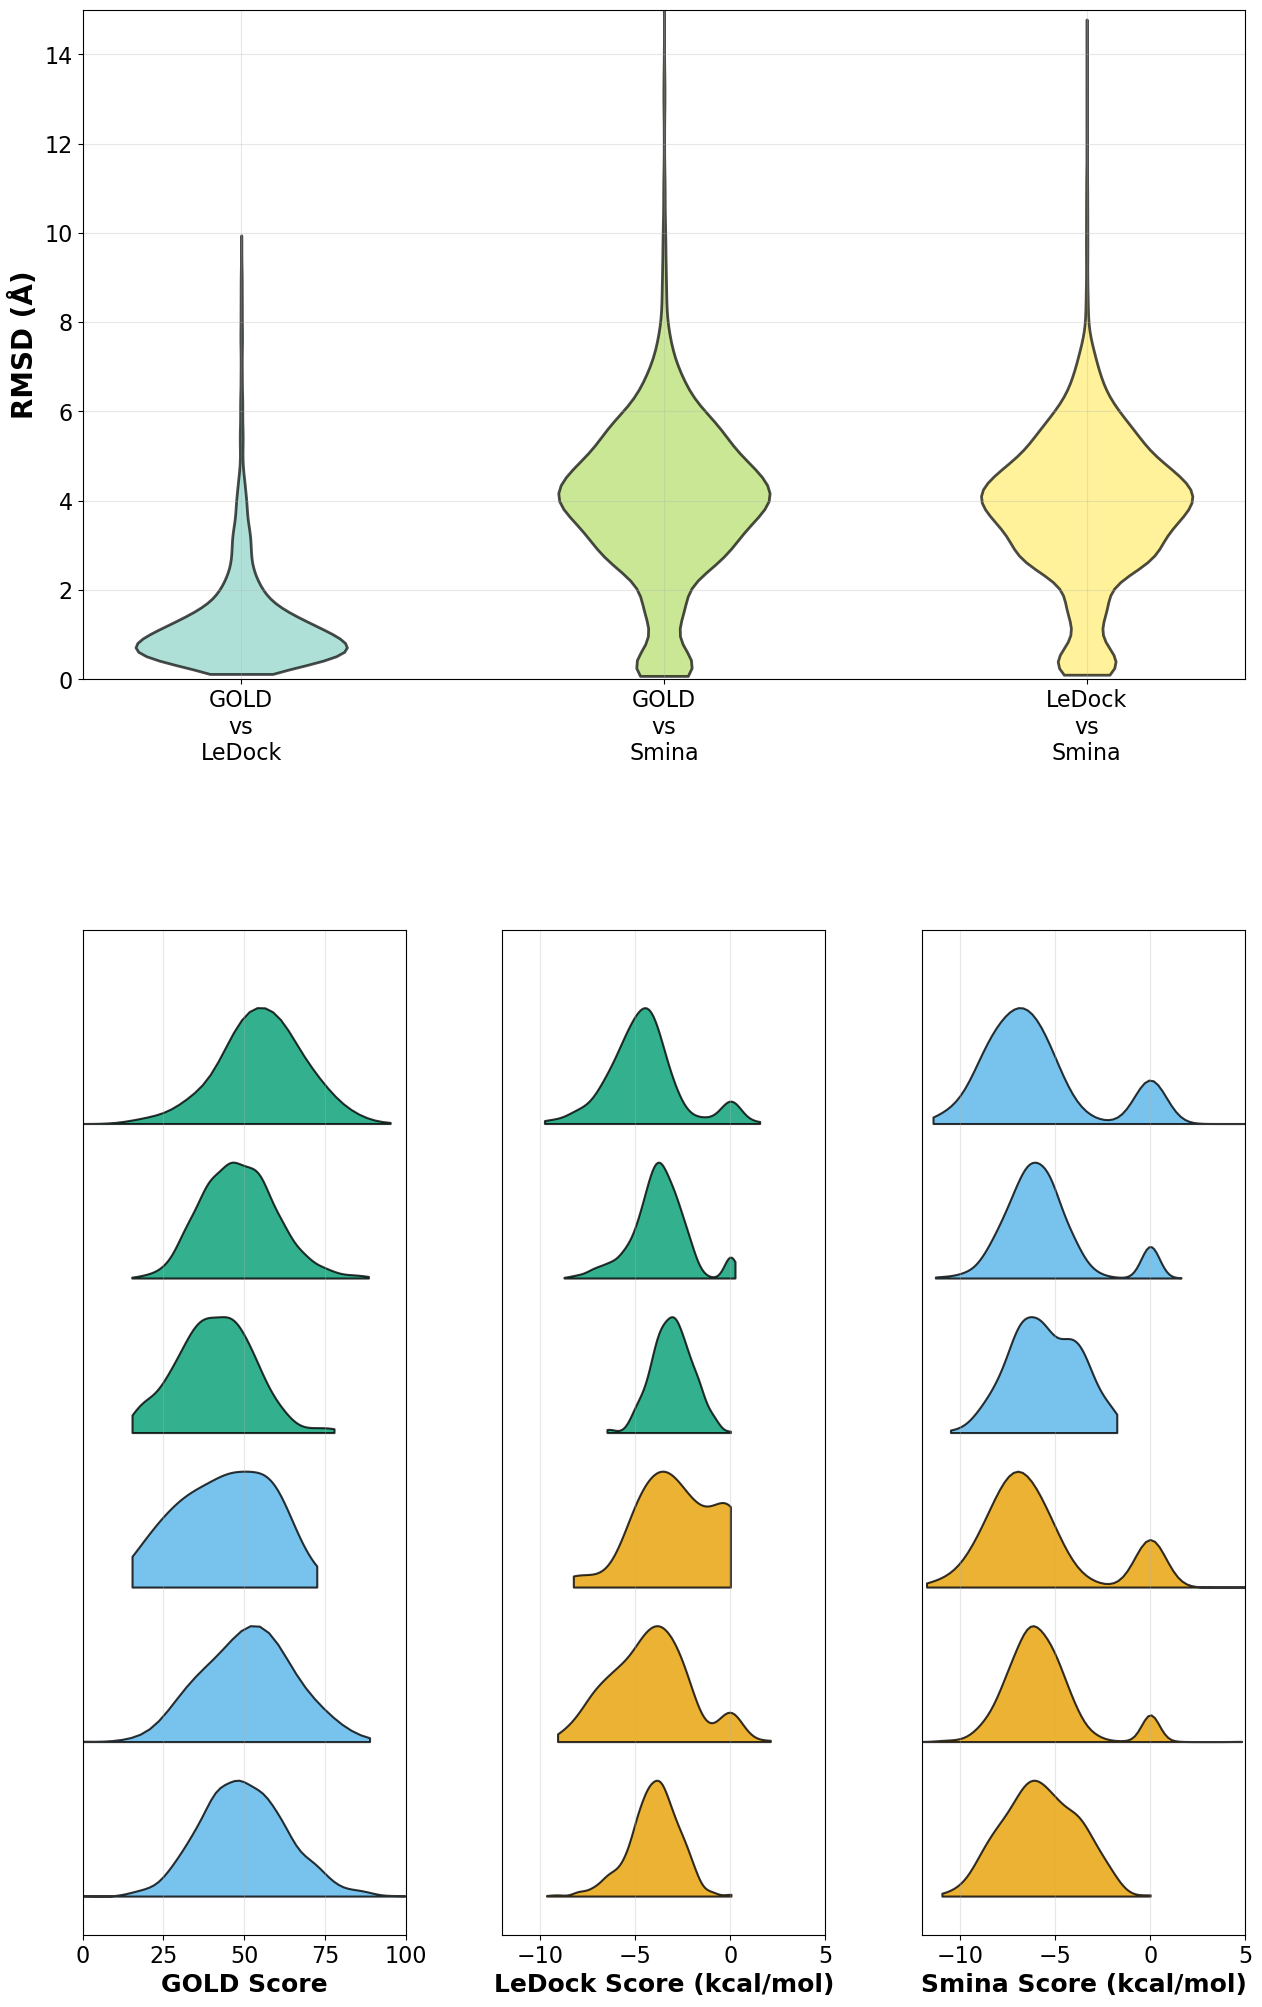


📈 SCORE DISTRIBUTION BY TOOL PAIR AND RMSD RANGE:

🔧 GOLD vs LeDock:
   <2Å:
     GOLD: n=2315, Mean=49.78±13.59
     LeDock: n=2315, Mean=-4.06±1.34
   2-5Å:
     GOLD: n=403, Mean=50.26±18.63
     LeDock: n=403, Mean=-4.24±2.09
   >5Å:
     GOLD: n=65, Mean=43.94±14.08
     LeDock: n=65, Mean=-2.81±2.09

🔧 GOLD vs Smina:
   <2Å:
     GOLD: n=354, Mean=40.93±11.68
     Smina: n=354, Mean=-5.77±1.93
   2-5Å:
     GOLD: n=1732, Mean=48.36±11.46
     Smina: n=1732, Mean=-5.69±2.08
   >5Å:
     GOLD: n=697, Mean=54.34±17.34
     Smina: n=697, Mean=-5.84±3.03

🔧 LeDock vs Smina:
   <2Å:
     LeDock: n=361, Mean=-3.09±1.05
     Smina: n=361, Mean=-5.56±1.78
   2-5Å:
     LeDock: n=1849, Mean=-3.75±1.49
     Smina: n=1849, Mean=-5.65±2.17
   >5Å:
     LeDock: n=573, Mean=-4.55±1.92
     Smina: n=573, Mean=-5.95±2.97

📈 TOOL AGREEMENT SUMMARY:
🏆 Tool pairs ranked by agreement (best to worst):
   1. GOLD vs LeDock: 1.34 ± 1.24 Å (median: 0.96 Å, n=2,783)
   2. LeDock vs Smina: 3.82 ± 1.68 Å (

In [16]:
# =============================================================================
# 📊 PLOT 1A: TOOL AGREEMENT DISTRIBUTION ANALYSIS
# =============================================================================

if not combined_results.is_empty() and 'RMSD' in combined_results.columns and 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
    
    print("🔥 Generating Tool Agreement Distribution Analysis...")
    
    # Set up poster-quality plotting parameters
    plt.rcParams.update({
        'figure.figsize': (16, 20),      # Vertical layout - taller figure
        'font.size': 18,                 # Even larger base font size
        'axes.titlesize': 22,            # Even larger title font
        'axes.labelsize': 20,            # Even larger axis labels
        'xtick.labelsize': 16,           # Even larger tick labels
        'ytick.labelsize': 16,           # Even larger tick labels
        'legend.fontsize': 16,           # Even larger legend font
        'figure.titlesize': 26           # Even larger figure title
    })
    
    # Convert to pandas for easier manipulation
    df = combined_results.to_pandas()
    
    # Get all unique tools
    all_tools = sorted(list(set(df['Tool1'].unique().tolist() + df['Tool2'].unique().tolist())))
    print(f"🔧 Detected tools: {all_tools}")
    
    # Check for score columns
    score_columns = [col for col in df.columns if any(x in col.lower() for x in ['score', 'energy', 'affinity'])]
    print(f"📊 Available scoring columns: {score_columns}")
    
    # Collect RMSD distributions and scores for unique tool pairs
    print("📊 Computing tool agreement distributions using lowest RMSD per drug-target pair...")
    
    tool_pair_data = []
    
    # Only consider unique pairs (avoid duplicates like A-B and B-A)
    from itertools import combinations
    unique_tool_pairs = list(combinations(all_tools, 2))
    
    for tool1, tool2 in unique_tool_pairs:
        # Find all comparisons between these two tools (both directions)
        mask1 = (df['Tool1'] == tool1) & (df['Tool2'] == tool2)
        mask2 = (df['Tool1'] == tool2) & (df['Tool2'] == tool1)
        
        if mask1.any() or mask2.any():
            # We need to track which tool is which for score assignment
            # Include score information and tool identity
            columns_to_include = ['drugbank_id', 'uniprot_id', 'cavity_index', 'RMSD', 'Tool1', 'Tool2'] + score_columns[:2]
            
            # Separate the two directions to maintain tool identity
            comparisons_direction1 = df.loc[mask1, columns_to_include].copy() if mask1.any() else pd.DataFrame()
            comparisons_direction2 = df.loc[mask2, columns_to_include].copy() if mask2.any() else pd.DataFrame()
            
            # For direction 2, we need to swap the tools and scores to maintain consistency
            if not comparisons_direction2.empty:
                # Create a copy and swap Tool1/Tool2 and Score1/Score2
                comparisons_direction2_swapped = comparisons_direction2.copy()
                comparisons_direction2_swapped['Tool1'], comparisons_direction2_swapped['Tool2'] = comparisons_direction2['Tool2'], comparisons_direction2['Tool1']
                if 'Score1' in comparisons_direction2_swapped.columns and 'Score2' in comparisons_direction2_swapped.columns:
                    comparisons_direction2_swapped['Score1'], comparisons_direction2_swapped['Score2'] = comparisons_direction2['Score2'], comparisons_direction2['Score1']
                comparisons_direction2 = comparisons_direction2_swapped
            
            # Combine both directions
            if not comparisons_direction1.empty and not comparisons_direction2.empty:
                comparisons = pd.concat([comparisons_direction1, comparisons_direction2])
            elif not comparisons_direction1.empty:
                comparisons = comparisons_direction1
            elif not comparisons_direction2.empty:
                comparisons = comparisons_direction2
            else:
                continue
            
            # Group by unique drug-target combinations and get the lowest RMSD for each
            grouped = comparisons.groupby(['drugbank_id', 'uniprot_id'])
            
            best_agreements = []
            for (drug, target), group in grouped:
                best_idx = group['RMSD'].idxmin()
                best_row = group.loc[best_idx]
                
                agreement_data = {
                    'drug': drug,
                    'target': target,
                    'rmsd': best_row['RMSD'],
                    'tool1_name': best_row['Tool1'],  # This should be tool1
                    'tool2_name': best_row['Tool2'],  # This should be tool2
                }
                
                # Add scores for each tool
                if 'Score1' in best_row and pd.notna(best_row['Score1']):
                    agreement_data['tool1_score'] = best_row['Score1']  # Score for tool1
                if 'Score2' in best_row and pd.notna(best_row['Score2']):
                    agreement_data['tool2_score'] = best_row['Score2']  # Score for tool2
                
                best_agreements.append(agreement_data)
            
            if len(best_agreements) > 0:
                rmsds = [item['rmsd'] for item in best_agreements]
                
                tool_pair_data.append({
                    'tool_pair': f"{tool1} vs {tool2}",
                    'tool1': tool1,
                    'tool2': tool2,
                    'rmsds': np.array(rmsds),
                    'agreements': best_agreements,
                    'n_pairs': len(best_agreements),
                    'mean_rmsd': np.mean(rmsds),
                    'median_rmsd': np.median(rmsds),
                    'std_rmsd': np.std(rmsds)
                })
                print(f"   {tool1} vs {tool2}: {len(best_agreements):,} unique drug-target pairs, Mean: {np.mean(rmsds):.2f} Å")
    
    if tool_pair_data:
        # Create main figure with custom layout: top plot + 3 horizontal ridge plots
        fig = plt.figure(figsize=(15, 25))
        gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.5], hspace=0.3, wspace=0.3)
        
        # ========================================================================
        # PLOT 1: RMSD Distribution Violin Plots (Top - spans all columns)
        # ========================================================================
        ax_rmsd = fig.add_subplot(gs[0, :])
        
        tool_pair_names = [data['tool_pair'] for data in tool_pair_data]
        rmsd_distributions = [data['rmsds'] for data in tool_pair_data]
        
        # Create violin plot with clear borders
        violins = ax_rmsd.violinplot(rmsd_distributions, positions=range(len(tool_pair_names)), 
                                    showmeans=False, showmedians=False, showextrema=False)
        
        # Customize violin colors with clear borders
        colors = plt.cm.Set3(np.linspace(0, 1, len(tool_pair_names)))
        for i, violin in enumerate(violins['bodies']):
            violin.set_facecolor(colors[i])
            violin.set_alpha(0.7)
            violin.set_edgecolor('black')  # Clear borders
            violin.set_linewidth(2)       # Thick borders
        
        ax_rmsd.set_xticks(range(len(tool_pair_names)))
        # Simplified x-axis labels - just the tool pair names
        simplified_labels = [name.replace(' vs ', '\nvs\n') for name in tool_pair_names]
        ax_rmsd.set_xticklabels(simplified_labels, rotation=0, ha='center', fontsize=16)
        ax_rmsd.set_ylabel('RMSD (Å)', fontsize=20, fontweight='bold')  # Add y-axis label
        ax_rmsd.grid(True, alpha=0.3)
        ax_rmsd.set_ylim(0, min(15, max([data['rmsds'].max() for data in tool_pair_data])))
        
        # ========================================================================
        # PLOTS 2-4: Ridge-style Score Distributions (Bottom - 3 horizontal plots)
        # ========================================================================
        
        # Check if we have score data
        has_score_data = any('tool1_score' in agreement or 'tool2_score' in agreement 
                           for data in tool_pair_data for agreement in data['agreements'])
        
        if has_score_data and len(tool_pair_data) > 0:
            print("📊 Creating ridge-style score distribution analysis...")
            
            # Define partner tool colors (color-blind friendly palette)
            partner_tool_colors = {
                'GOLD': '#E69F00',     # Orange (deuteranopia/protanopia safe)
                'LeDock': '#56B4E9',   # Sky Blue (tritanopia safe)
                'Smina': '#009E73'     # Bluish Green (all color-blind types safe)
            }
            
            # Define RMSD ranges with actual numeric values
            rmsd_ranges = [
                (0, 2, "<2Å"),
                (2, 5, "2-5Å"),
                (5, float('inf'), ">5Å")
            ]
            
            # Create horizontal ridge plots for each tool
            for tool_idx, tool in enumerate(all_tools):
                if tool_idx > 2:  # Only use first 3 tools (we have 3 horizontal subplots)
                    break
                    
                ax_tool = fig.add_subplot(gs[1, tool_idx])
                
                print(f"   Creating ridge plot for {tool}...")
                
                # Collect all score data for this tool across all tool pairs and RMSD ranges
                y_position = 0
                y_spacing = 0.8  # Overlapping ridges
                max_y = 0
                ridge_data = []  # Store ridge data for annotations
                
                # For each tool pair involving this tool
                for pair_idx, data in enumerate(tool_pair_data):
                    # Check if this tool is tool1 or tool2 in the pair
                    if data['tool1'] == tool:
                        partner_tool = data['tool2']
                        score_key = 'tool1_score'
                    elif data['tool2'] == tool:
                        partner_tool = data['tool1']
                        score_key = 'tool2_score'
                    else:
                        continue
                    
                    # Get partner tool color (use partner tool's color, not current tool's color)
                    ridge_color = partner_tool_colors.get(partner_tool, '#ADD8E6')
                    
                    # For each RMSD range
                    for range_idx, (rmsd_min, rmsd_max, range_name) in enumerate(rmsd_ranges):
                        # Collect scores for this tool in this RMSD range
                        tool_scores = []
                        for agreement in data['agreements']:
                            if (rmsd_min <= agreement['rmsd'] < rmsd_max and 
                                score_key in agreement and pd.notna(agreement[score_key])):
                                tool_scores.append(agreement[score_key])
                        
                        if len(tool_scores) >= 5:  # Only plot if we have sufficient data
                            try:
                                from scipy.stats import gaussian_kde
                                
                                # Create density curve
                                kde = gaussian_kde(tool_scores)
                                score_range = np.linspace(min(tool_scores), max(tool_scores), 100)
                                density = kde(score_range)
                                
                                # Normalize density for ridge plot appearance
                                density = density / density.max() * 0.6  # Scale height
                                
                                # Plot the ridge with clear borders
                                ax_tool.fill_between(score_range, y_position, y_position + density, 
                                                    alpha=0.8, color=ridge_color, 
                                                    edgecolor='black', linewidth=1.5)
                                
                                # Store ridge data for annotation (removed RMSD annotations)
                                ridge_data.append({
                                    'y_center': y_position + 0.3,
                                    'x_center': np.median(tool_scores),
                                    'partner_tool': partner_tool
                                })
                                
                                y_position += y_spacing
                                max_y = max(max_y, y_position)
                                
                            except Exception as e:
                                print(f"Warning: Could not create KDE for {tool} vs {partner_tool} in {range_name} range: {e}")
                                continue
                
                # Customize the subplot - add x-axis label with units
                ax_tool.set_ylabel('')  # Remove y-axis title
                if tool in ['LeDock', 'Smina']:
                    ax_tool.set_xlabel(f'{tool} Score (kcal/mol)', fontsize=18, fontweight='bold')  # Add units
                else:  # GOLD has no unit
                    ax_tool.set_xlabel(f'{tool} Score', fontsize=18, fontweight='bold')  # No unit for GOLD
                ax_tool.grid(True, alpha=0.3)
                
                # Set appropriate x-axis limits based on tool - extend LeDock/Smina to include positive values
                if tool == 'GOLD':
                    ax_tool.set_xlim(0, 100)
                else:  # LeDock and Smina use negative scores, but extend to positive values up to 5
                    ax_tool.set_xlim(-12, 5)
                
                # Set y-axis limits and remove ticks
                if max_y > 0:
                    ax_tool.set_ylim(-0.2, max_y + 0.2)
                ax_tool.set_yticks([])
                
                # Remove RMSD range annotations (simplified for cleaner look)
                # for ridge_info in ridge_data:
                #     annotation_text = f"{ridge_info['range_name']} vs {ridge_info['partner_tool']}"
                #     ax_tool.text(ridge_info['x_center'], ridge_info['y_center'], annotation_text,
                #                ha='center', va='center', fontsize=10, fontweight='bold',
                #                color=range_colors.get(ridge_info['range_name'], 'black'),
                #                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
                
                if max_y == 0:  # No data was plotted
                    ax_tool.text(0.5, 0.5, f'Insufficient score data\nfor {tool}', 
                               ha='center', va='center', transform=ax_tool.transAxes, 
                               fontsize=16, fontweight='bold')
        
        else:
            # No score data - show message in remaining subplots
            for i in range(3):
                ax_tool = fig.add_subplot(gs[1, i])
                ax_tool.text(0.5, 0.5, 'No score data available', 
                           ha='center', va='center', transform=ax_tool.transAxes, 
                           fontsize=18, fontweight='bold')
                # Add x-axis labels even when no data
                if i < len(all_tools):
                    if all_tools[i] in ['LeDock', 'Smina']:
                        ax_tool.set_xlabel(f'{all_tools[i]} Score (kcal/mol)', fontsize=18, fontweight='bold')
                    else:
                        ax_tool.set_xlabel(f'{all_tools[i]} Score', fontsize=18, fontweight='bold')
        
        plt.tight_layout(pad=1.5)  # Add padding for better spacing
        plt.show()
        
        # Print detailed statistics - also update the printed ranges to use actual values
        print(f"\n📈 SCORE DISTRIBUTION BY TOOL PAIR AND RMSD RANGE:")
        print("=" * 70)
        
        for data in tool_pair_data:
            print(f"\n🔧 {data['tool_pair']}:")
            
            # Define RMSD ranges
            rmsd_ranges = [
                (0, 2, "<2Å"),
                (2, 5, "2-5Å"),
                (5, float('inf'), ">5Å")
            ]
            
            for i, (min_rmsd, max_rmsd, range_name) in enumerate(rmsd_ranges):
                # Count scores for each tool in this range
                tool1_scores = []
                tool2_scores = []
                
                for agreement in data['agreements']:
                    if min_rmsd <= agreement['rmsd'] < max_rmsd:
                        if 'tool1_score' in agreement and pd.notna(agreement['tool1_score']):
                            tool1_scores.append(agreement['tool1_score'])
                        if 'tool2_score' in agreement and pd.notna(agreement['tool2_score']):
                            tool2_scores.append(agreement['tool2_score'])
                
                print(f"   {range_name}:")
                if tool1_scores:
                    print(f"     {data['tool1']}: n={len(tool1_scores)}, Mean={np.mean(tool1_scores):.2f}±{np.std(tool1_scores):.2f}")
                else:
                    print(f"     {data['tool1']}: No data")
                    
                if tool2_scores:
                    print(f"     {data['tool2']}: n={len(tool2_scores)}, Mean={np.mean(tool2_scores):.2f}±{np.std(tool2_scores):.2f}")
                else:
                    print(f"     {data['tool2']}: No data")
        
        # Summary statistics for RMSD agreement
        print(f"\n📈 TOOL AGREEMENT SUMMARY:")
        print("=" * 60)
        
        # Sort by mean agreement (best to worst)
        sorted_pairs = sorted(tool_pair_data, key=lambda x: x['mean_rmsd'])
        
        print("🏆 Tool pairs ranked by agreement (best to worst):")
        for i, data in enumerate(sorted_pairs, 1):
            print(f"   {i}. {data['tool_pair']}: {data['mean_rmsd']:.2f} ± {data['std_rmsd']:.2f} Å "
                  f"(median: {data['median_rmsd']:.2f} Å, n={data['n_pairs']:,})")
        
        # Overall statistics
        all_means = [data['mean_rmsd'] for data in tool_pair_data]
        best_agreement = min(all_means)
        worst_agreement = max(all_means)
        
        print(f"\n📊 Overall agreement statistics:")
        print(f"   Best tool pair agreement: {best_agreement:.2f} Å")
        print(f"   Worst tool pair agreement: {worst_agreement:.2f} Å")
        print(f"   Average across all pairs: {np.mean(all_means):.2f} ± {np.std(all_means):.2f} Å")
        
    else:
        print("❌ No valid tool pairs found for agreement analysis")
    
    # Reset matplotlib parameters to defaults
    plt.rcdefaults()
    
else:
    print("❌ Cannot generate tool agreement distribution - missing required data")
    print("   Required: RMSD, Tool1, Tool2 columns")


## Research Question 2: Cluster-Based Distinction of Preferred vs Non-Preferred Cavities

This section investigates whether **cavity cluster membership** can distinguish between **preferred and non-preferred binding sites** for each drug-target combination.

### Key Research Question:
**Can we distinguish between preferred cavities and other cavities based on their cluster membership patterns?**

### Analysis Strategy:
1. **Define Preferred Cavities**: For each unique drug-uniprot combination, identify preferred cavities using multiple criteria:
   - **Lowest RMSD** (best structural agreement between tools)
   - **Best Score1** (optimal docking score from primary tool)
   - **Best Score2** (optimal docking score from secondary tool)

2. **Cluster Comparison**: Compare the cluster membership patterns between:
   - **Preferred cavities** (selected by each criterion)
   - **Non-preferred cavities** (all other cavities for the same drug-target pair)

3. **Statistical Analysis**: Test whether preferred and non-preferred cavities come from significantly different cluster distributions

4. **Visualization**: Generate comparative plots showing cluster characteristics for preferred vs non-preferred cavities

### Expected Insights:
- Whether certain cavity clusters are systematically preferred across drug-target pairs
- How different preference criteria (RMSD vs scores) affect cluster selection patterns
- Statistical significance of cluster-based cavity preferences

In [17]:
print("=== Research Question 2: Preferred vs Non-Preferred Cavity Analysis ===")

# Convert to pandas for easier manipulation
df_rq2 = combined_results.to_pandas()

# Check if we have cluster information
if 'cavity_cluster_id' not in df_rq2.columns:
    print("❌ No cluster information available - cannot perform cluster-based analysis")
    rq2_analysis = None
else:
    print("✅ Cluster information available - proceeding with analysis")
    
    # Remove rows without cluster information
    df_rq2_clean = df_rq2.dropna(subset=['cavity_cluster_id']).copy()
    print(f"Dataset for RQ2: {len(df_rq2_clean):,} rows with cluster information")
    
    # First, let's extract individual tool scores for each cavity
    print("\n🔍 Extracting individual tool scores for each cavity...")
    
    # Create a comprehensive dataset with all tool scores per cavity
    cavity_scores = {}  # Key: (drug, target, cavity), Value: {tool_scores, rmsd_info, cluster}
    
    for _, row in df_rq2_clean.iterrows():
        key = (row['drugbank_id'], row['uniprot_id'], row['cavity_index'])
        
        if key not in cavity_scores:
            cavity_scores[key] = {
                'drug': row['drugbank_id'],
                'target': row['uniprot_id'],
                'cavity_index': row['cavity_index'],
                'cluster_id': row['cavity_cluster_id'],
                'tool_scores': {},
                'rmsd_data': []
            }
        
        # Store individual tool scores
        tool1 = row['Tool1']
        tool2 = row['Tool2']
        
        if pd.notna(tool1) and pd.notna(row['Score1']):
            cavity_scores[key]['tool_scores'][tool1] = row['Score1']
        if pd.notna(tool2) and pd.notna(row['Score2']):
            cavity_scores[key]['tool_scores'][tool2] = row['Score2']
        
        # Store RMSD information
        cavity_scores[key]['rmsd_data'].append({
            'tool1': tool1,
            'tool2': tool2,
            'rmsd': row['RMSD']
        })
    
    print(f"✅ Extracted scores for {len(cavity_scores):,} unique cavities")
    
    # Calculate minimum RMSD for each cavity (across all tool pairs)
    # This represents the best consensus pose for each cavity
    for key in cavity_scores:
        rmsd_values = [item['rmsd'] for item in cavity_scores[key]['rmsd_data'] if pd.notna(item['rmsd'])]
        cavity_scores[key]['min_rmsd'] = np.min(rmsd_values) if rmsd_values else np.nan
        cavity_scores[key]['avg_rmsd'] = np.mean(rmsd_values) if rmsd_values else np.nan  # Keep for reference
    
    # Define preference criteria with proper tool names
    preference_criteria = {
        'lowest_rmsd': 'Best Consensus (Min RMSD)',
        'best_gold': 'Best GOLD Score',
        'best_ledock': 'Best LeDock Score',
        'best_smina': 'Best Smina Score'
    }
    
    # Initialize results storage
    rq2_analysis = {
        'preferred_cavities': {},
        'cluster_comparisons': {},
        'statistical_tests': {},
        'summary_stats': {}
    }
    
    print(f"\nAnalyzing {len(preference_criteria)} preference criteria...")
    
    # For each preference criterion
    for criterion_key, criterion_name in preference_criteria.items():
        print(f"\n--- Analyzing {criterion_name} preference ---")
        
        # Storage for this criterion
        preferred_cavities = []
        non_preferred_cavities = []
        preferred_clusters = []
        non_preferred_clusters = []
        
        # Group cavities by drug-target pairs
        drug_target_cavities = {}
        for key, cavity_data in cavity_scores.items():
            dt_key = (cavity_data['drug'], cavity_data['target'])
            if dt_key not in drug_target_cavities:
                drug_target_cavities[dt_key] = []
            drug_target_cavities[dt_key].append(cavity_data)
        
        valid_pairs = 0
        
        for (drug, target), cavities in drug_target_cavities.items():
            if len(cavities) < 2:  # Need at least 2 cavities to distinguish preferred vs non-preferred
                continue
            
            # Filter cavities based on available data for this criterion
            if criterion_key == 'lowest_rmsd':
                valid_cavities = [c for c in cavities if pd.notna(c['min_rmsd'])]
                if len(valid_cavities) < 2:
                    continue
                # Find cavity with lowest minimum RMSD (best consensus)
                preferred_cavity = min(valid_cavities, key=lambda x: x['min_rmsd'])
            elif criterion_key == 'best_gold':
                valid_cavities = [c for c in cavities if 'GOLD' in c['tool_scores']]
                if len(valid_cavities) < 2:
                    continue
                # Find cavity with best (highest) GOLD score
                preferred_cavity = max(valid_cavities, key=lambda x: x['tool_scores']['GOLD'])
            elif criterion_key == 'best_ledock':
                valid_cavities = [c for c in cavities if 'LeDock' in c['tool_scores']]
                if len(valid_cavities) < 2:
                    continue
                # Find cavity with best (most negative) LeDock score
                preferred_cavity = min(valid_cavities, key=lambda x: x['tool_scores']['LeDock'])
            elif criterion_key == 'best_smina':
                valid_cavities = [c for c in cavities if 'Smina' in c['tool_scores']]
                if len(valid_cavities) < 2:
                    continue
                # Find cavity with best (most negative) Smina score
                preferred_cavity = min(valid_cavities, key=lambda x: x['tool_scores']['Smina'])
            
            # Store preferred cavity info
            preferred_cavities.append(preferred_cavity)
            preferred_clusters.append(preferred_cavity['cluster_id'])
            
            # Store non-preferred cavity info
            non_preferred = [c for c in valid_cavities if c != preferred_cavity]
            non_preferred_cavities.extend(non_preferred)
            non_preferred_clusters.extend([c['cluster_id'] for c in non_preferred])
            
            valid_pairs += 1
        
        # Store results for this criterion
        rq2_analysis['preferred_cavities'][criterion_key] = {
            'preferred': preferred_cavities,
            'non_preferred': non_preferred_cavities,
            'preferred_clusters': preferred_clusters,
            'non_preferred_clusters': non_preferred_clusters,
            'n_drug_target_pairs': valid_pairs
        }
        
        print(f"   Analyzed {valid_pairs:,} drug-target pairs")
        print(f"   Preferred cavities: {len(preferred_cavities):,}")
        print(f"   Non-preferred cavities: {len(non_preferred_cavities):,}")
        print(f"   Unique preferred clusters: {len(set(preferred_clusters)):,}")
        print(f"   Unique non-preferred clusters: {len(set(non_preferred_clusters)):,}")
    
    print(f"\n✅ Completed preferred cavity identification for all criteria")
    
    # Calculate cluster statistics for comparison
    print(f"\n=== CLUSTER COMPARISON STATISTICS ===")
    
    for criterion_key, criterion_name in preference_criteria.items():
        data = rq2_analysis['preferred_cavities'][criterion_key]
        
        if len(data['preferred_clusters']) == 0:
            continue
            
        print(f"\n{criterion_name}:")
        
        # Convert to pandas Series for analysis
        preferred_clusters_series = pd.Series(data['preferred_clusters'])
        non_preferred_clusters_series = pd.Series(data['non_preferred_clusters'])
        
        # Cluster frequency analysis
        preferred_cluster_counts = preferred_clusters_series.value_counts()
        non_preferred_cluster_counts = non_preferred_clusters_series.value_counts()
        
        # Top preferred clusters
        top_preferred = preferred_cluster_counts.head(5)
        print(f"   Top 5 preferred clusters: {dict(top_preferred)}")
        
        # Statistical comparison using Chi-square test
        from scipy.stats import chi2_contingency
        
        # Create contingency table
        all_clusters = set(data['preferred_clusters'] + data['non_preferred_clusters'])
        
        contingency_data = []
        for cluster in all_clusters:
            pref_count = preferred_cluster_counts.get(cluster, 0)
            non_pref_count = non_preferred_cluster_counts.get(cluster, 0)
            contingency_data.append([pref_count, non_pref_count])
        
        if len(contingency_data) > 1:
            contingency_table = np.array(contingency_data)
            
            # Perform chi-square test
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                rq2_analysis['statistical_tests'][criterion_key] = {
                    'chi2_statistic': chi2,
                    'p_value': p_value,
                    'degrees_of_freedom': dof,
                    'significant': p_value < 0.05
                }
                
                print(f"   Chi-square test: χ² = {chi2:.3f}, p = {p_value:.6f}")
                print(f"   {'✅ Significant' if p_value < 0.05 else '❌ Not significant'} difference in cluster distributions")
                
            except Exception as e:
                print(f"   ⚠️ Could not perform chi-square test: {e}")
    
    print(f"\n✅ Statistical analysis completed")

=== Research Question 2: Preferred vs Non-Preferred Cavity Analysis ===
✅ Cluster information available - proceeding with analysis
Dataset for RQ2: 1,279,576 rows with cluster information

🔍 Extracting individual tool scores for each cavity...
✅ Extracted scores for 1,585 unique cavities

Analyzing 4 preference criteria...

--- Analyzing Best Consensus (Min RMSD) preference ---
   Analyzed 262 drug-target pairs
   Preferred cavities: 262
   Non-preferred cavities: 363
   Unique preferred clusters: 50
   Unique non-preferred clusters: 56

--- Analyzing Best GOLD Score preference ---
   Analyzed 257 drug-target pairs
   Preferred cavities: 257
   Non-preferred cavities: 335
   Unique preferred clusters: 47
   Unique non-preferred clusters: 52

--- Analyzing Best LeDock Score preference ---
   Analyzed 257 drug-target pairs
   Preferred cavities: 257
   Non-preferred cavities: 357
   Unique preferred clusters: 41
   Unique non-preferred clusters: 56

--- Analyzing Best Smina Score prefere

✅ RQ2 analysis found. Creating violin plots...
✅ Created split violin plot for Best Consensus
(Min RMSD)
✅ Created split violin plot for Best GOLD
Score
✅ Created split violin plot for Best LeDock
Score
✅ Created split violin plot for Best Smina
Score


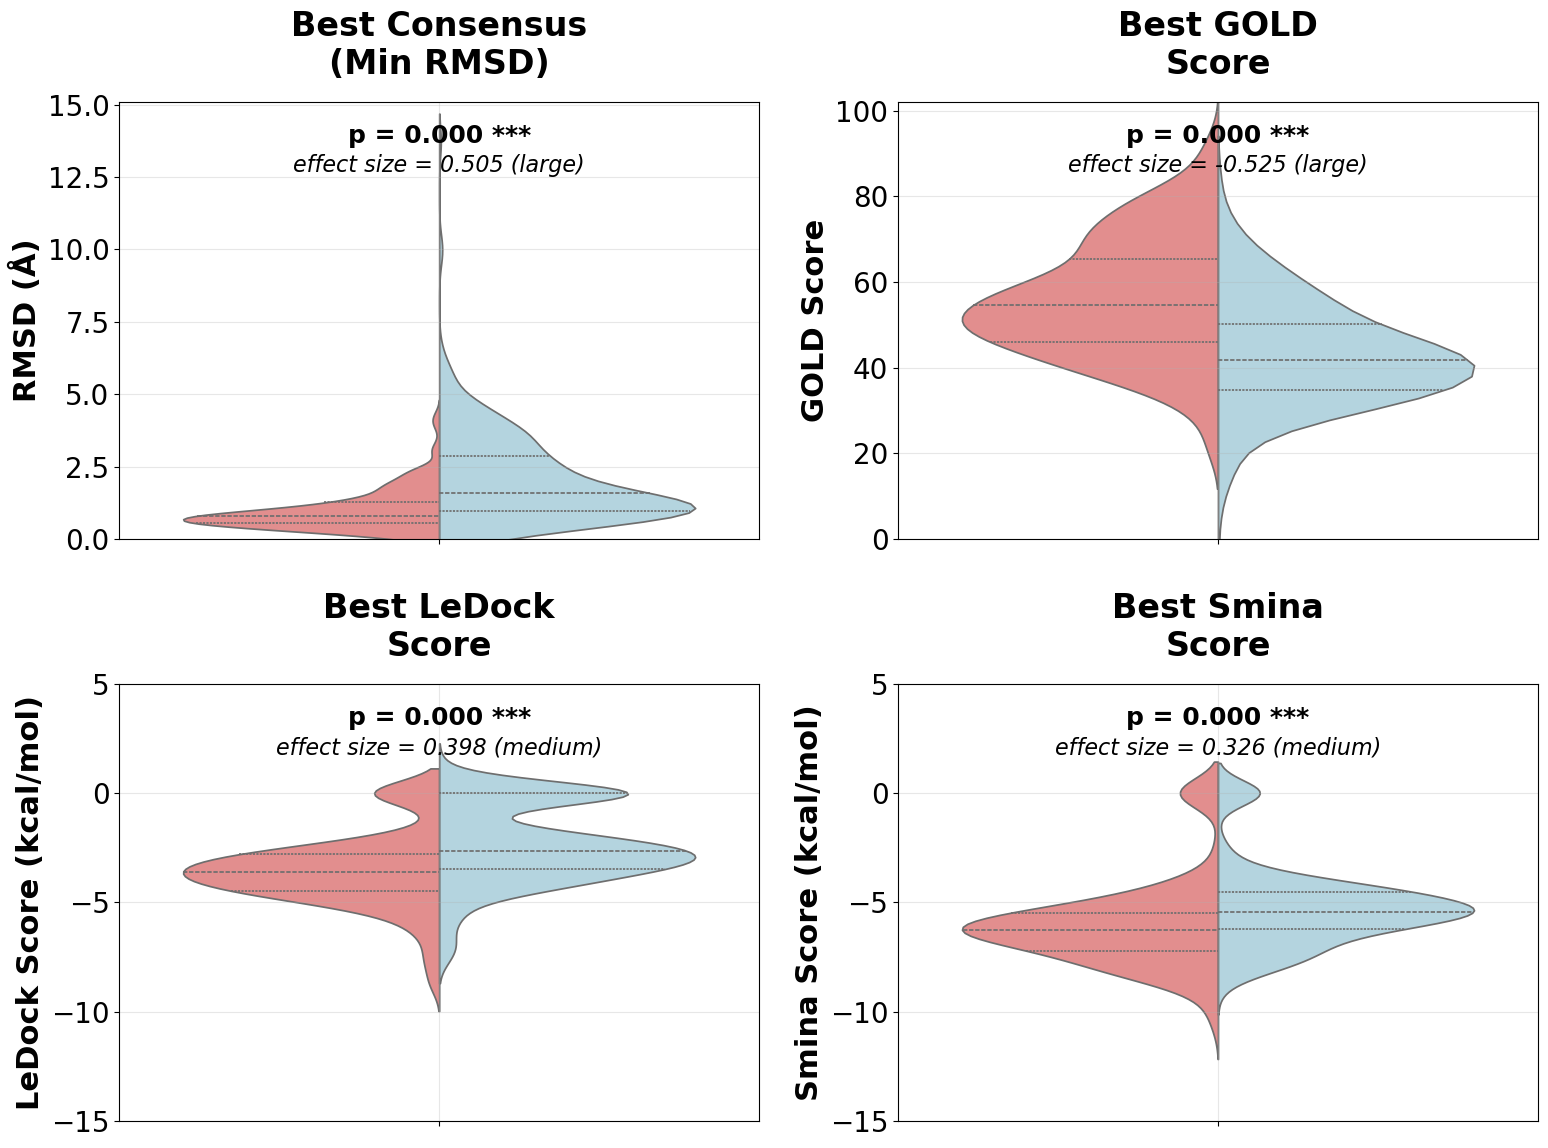


📊 COMPREHENSIVE SUMMARY STATISTICS:
Statistical Analysis Notes:
• Mann-Whitney U test used (appropriate for non-normal distributions)
• Effect size calculated using rank biserial correlation
• Effect size interpretation: negligible (<0.1), small (0.1-0.3), medium (0.3-0.5), large (>0.5)

Best Consensus (Min RMSD) - RMSD (Å):
  Drug-target pairs analyzed: 262
  Preferred cavities: 262
  Non-preferred cavities: 363

  RMSD (Å) Statistics:
    Preferred: n=262, median=0.801 Å (IQR: 0.545-1.261)
    Non-Preferred: n=363, median=1.584 Å (IQR: 0.955-2.870)

Best GOLD Score - GOLD Score:
  Drug-target pairs analyzed: 257
  Preferred cavities: 257
  Non-preferred cavities: 335

  GOLD Score Statistics:
    Preferred: n=257, median=54.680  (IQR: 46.020-65.460)
    Non-Preferred: n=335, median=41.700  (IQR: 34.755-50.120)

Best LeDock Score - LeDock Score (kcal/mol):
  Drug-target pairs analyzed: 257
  Preferred cavities: 257
  Non-preferred cavities: 357

  LeDock Score (kcal/mol) Statistics:


In [18]:
# ==============================================================================
# 📊 RQ2: Violin Plots for Preferred vs Non-Preferred Cavities (Individual Tool Scores)
# ===============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

# Check if RQ2 analysis exists
if 'rq2_analysis' not in globals() or rq2_analysis is None:
    print("❌ RQ2 analysis not found. Please run the previous RQ2 analysis cell first.")
else:
    print("✅ RQ2 analysis found. Creating violin plots...")
    
    # Set up poster-quality plotting parameters (matching RQ1)
    plt.rcParams.update({
        'font.size': 24,                 # Larger base font size
        'axes.titlesize': 28,            # Larger title font
        'axes.labelsize': 22,            # Larger axis labels
        'xtick.labelsize': 22,           # Larger tick labels
        'ytick.labelsize': 20,           # Larger tick labels
        'legend.fontsize': 22,           # Larger legend font
        'figure.titlesize': 32           # Larger figure title
    })
    
    # Define preference criteria with their corresponding metrics
    preference_criteria = {
        'lowest_rmsd': {'name': 'Best Consensus\n(Min RMSD)', 'metric': 'RMSD (Å)'},
        'best_gold': {'name': 'Best GOLD\nScore', 'metric': 'GOLD Score'},
        'best_ledock': {'name': 'Best LeDock\nScore', 'metric': 'LeDock Score (kcal/mol)'},
        'best_smina': {'name': 'Best Smina\nScore', 'metric': 'Smina Score (kcal/mol)'}
    }
    
    # Count how many criteria have data
    valid_criteria = []
    for criterion_key, criterion_info in preference_criteria.items():
        if criterion_key in rq2_analysis['preferred_cavities'] and len(rq2_analysis['preferred_cavities'][criterion_key]['preferred']) > 0:
            valid_criteria.append((criterion_key, criterion_info))
    
    if len(valid_criteria) == 0:
        print("❌ No valid criteria with data found")
    else:
        # Create 2x2 subplot grid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()  # Flatten for easy indexing
        
        # Loop over each valid preference criterion
        for idx, (criterion_key, criterion_info) in enumerate(valid_criteria):
            if idx >= 4:  # Only show first 4 criteria
                break
                
            ax = axes[idx]
            data = rq2_analysis['preferred_cavities'][criterion_key]
            criterion_name = criterion_info['name']
            metric = criterion_info['metric']
            
            # Prepare data for this specific metric
            metric_data = []
            
            if metric == 'RMSD (Å)':
                # RMSD data - use minimum RMSD for each cavity
                for cavity in data['preferred']:
                    if 'min_rmsd' in cavity and pd.notna(cavity['min_rmsd']):
                        metric_data.append({'Preference': 'Preferred', 'Value': cavity['min_rmsd']})
                for cavity in data['non_preferred']:
                    if 'min_rmsd' in cavity and pd.notna(cavity['min_rmsd']):
                        metric_data.append({'Preference': 'Non-Preferred', 'Value': cavity['min_rmsd']})
            
            elif metric == 'GOLD Score':
                # GOLD scores
                for cavity in data['preferred']:
                    if 'tool_scores' in cavity and 'GOLD' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Preferred', 'Value': cavity['tool_scores']['GOLD']})
                for cavity in data['non_preferred']:
                    if 'tool_scores' in cavity and 'GOLD' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Non-Preferred', 'Value': cavity['tool_scores']['GOLD']})
            
            elif metric == 'LeDock Score (kcal/mol)':
                # LeDock scores
                for cavity in data['preferred']:
                    if 'tool_scores' in cavity and 'LeDock' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Preferred', 'Value': cavity['tool_scores']['LeDock']})
                for cavity in data['non_preferred']:
                    if 'tool_scores' in cavity and 'LeDock' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Non-Preferred', 'Value': cavity['tool_scores']['LeDock']})
            
            elif metric == 'Smina Score (kcal/mol)':
                # Smina scores
                for cavity in data['preferred']:
                    if 'tool_scores' in cavity and 'Smina' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Preferred', 'Value': cavity['tool_scores']['Smina']})
                for cavity in data['non_preferred']:
                    if 'tool_scores' in cavity and 'Smina' in cavity['tool_scores']:
                        metric_data.append({'Preference': 'Non-Preferred', 'Value': cavity['tool_scores']['Smina']})
            
            # Plot if we have data
            if len(metric_data) > 0:
                df_metric = pd.DataFrame(metric_data)
                
                # Check if we have both preferred and non-preferred data
                prefs = df_metric['Preference'].unique()
                if len(prefs) > 1:
                    try:
                        # Create split violin plot using seaborn
                        df_metric['dummy'] = 'All'
                        sns.violinplot(
                            data=df_metric,
                            y='Value',
                            x='dummy',
                            hue='Preference',
                            ax=ax,
                            palette=['lightcoral', 'lightblue'],
                            inner='quartile',
                            split=True
                        )
                        
                        # Customize subplot
                        ax.set_title(f'{criterion_name}', fontsize=24, fontweight='bold', pad=20)
                        ax.set_ylabel(metric, fontsize=22, fontweight='bold')
                        ax.set_xlabel("")  # Remove x-axis label
                        ax.set_xticklabels([])  # Remove x-axis tick labels
                        ax.grid(True, alpha=0.3)
                        
                        # Remove legend (it's clear from context)
                        if ax.legend_:
                            ax.legend_.remove()
                        
                        # Set appropriate y-axis limits
                        if metric == 'RMSD (Å)':
                            ax.set_ylim(0, max(15, df_metric['Value'].max() * 1.1))
                        elif metric == 'GOLD Score':
                            ax.set_ylim(0, max(100, df_metric['Value'].max() * 1.1))
                        elif metric in ['LeDock Score (kcal/mol)', 'Smina Score (kcal/mol)']:
                            ax.set_ylim(min(-15, df_metric['Value'].min() * 1.1), 
                                       max(5, df_metric['Value'].max() * 1.1))
                        
                        # Enhanced statistical testing for non-normal data
                        preferred_vals = df_metric[df_metric['Preference'] == 'Preferred']['Value'].values
                        non_preferred_vals = df_metric[df_metric['Preference'] == 'Non-Preferred']['Value'].values
                        
                        if len(preferred_vals) > 0 and len(non_preferred_vals) > 0:
                            try:
                                # Mann-Whitney U test (appropriate for non-normal data)
                                stat, p_val = stats.mannwhitneyu(preferred_vals, non_preferred_vals, alternative='two-sided')
                                
                                # Calculate effect size (rank biserial correlation)
                                n1, n2 = len(preferred_vals), len(non_preferred_vals)
                                effect_size = 1 - (2 * stat) / (n1 * n2)
                                
                                # Interpret effect size
                                if abs(effect_size) < 0.1:
                                    effect_interpretation = "negligible"
                                elif abs(effect_size) < 0.3:
                                    effect_interpretation = "small"
                                elif abs(effect_size) < 0.5:
                                    effect_interpretation = "medium"
                                else:
                                    effect_interpretation = "large"
                                
                                # Determine significance
                                if p_val < 0.001:
                                    significance = "***"
                                elif p_val < 0.01:
                                    significance = "**"
                                elif p_val < 0.05:
                                    significance = "*"
                                else:
                                    significance = "ns"
                                
                                # Add statistical annotation with effect size
                                ax.text(0.5, 0.95, f'p = {p_val:.3f} {significance}', 
                                       transform=ax.transAxes, ha='center', va='top', 
                                       fontsize=18, fontweight='bold')
                                ax.text(0.5, 0.88, f'effect size = {effect_size:.3f} ({effect_interpretation})', 
                                       transform=ax.transAxes, ha='center', va='top', 
                                       fontsize=16, style='italic')
                                
                            except Exception as e:
                                print(f"⚠️ Statistical test failed for {criterion_name} - {metric}: {e}")
                        
                        print(f"✅ Created split violin plot for {criterion_name}")
                        
                    except Exception as e:
                        print(f"❌ Error creating violin plot for {criterion_name}: {e}")
                        ax.text(0.5, 0.5, f'Error creating plot', 
                               ha='center', va='center', transform=ax.transAxes, 
                               fontsize=20, fontweight='bold')
                else:
                    ax.text(0.5, 0.5, f'Only {prefs[0]} data available', 
                           ha='center', va='center', transform=ax.transAxes, 
                           fontsize=20, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No data available', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=20, fontweight='bold')
        
        # Hide any unused subplots
        for idx in range(len(valid_criteria), 4):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Print comprehensive summary statistics with improved statistical analysis
        print(f"\n📊 COMPREHENSIVE SUMMARY STATISTICS:")
        print("=" * 80)
        print("Statistical Analysis Notes:")
        print("• Mann-Whitney U test used (appropriate for non-normal distributions)")
        print("• Effect size calculated using rank biserial correlation")
        print("• Effect size interpretation: negligible (<0.1), small (0.1-0.3), medium (0.3-0.5), large (>0.5)")
        print("=" * 80)
        
        for criterion_key, criterion_info in valid_criteria:
            data = rq2_analysis['preferred_cavities'][criterion_key]
            criterion_name = criterion_info['name'].replace('\n', ' ')  # Remove newlines for clean printing
            metric = criterion_info['metric']
            
            print(f"\n{criterion_name} - {metric}:")
            print(f"  Drug-target pairs analyzed: {data['n_drug_target_pairs']:,}")
            print(f"  Preferred cavities: {len(data['preferred']):,}")
            print(f"  Non-preferred cavities: {len(data['non_preferred']):,}")
            
            # Get the appropriate statistics based on the metric
            if metric == 'RMSD (Å)':
                # Min RMSD statistics
                pref_vals = [c['min_rmsd'] for c in data['preferred'] if 'min_rmsd' in c and pd.notna(c['min_rmsd'])]
                non_pref_vals = [c['min_rmsd'] for c in data['non_preferred'] if 'min_rmsd' in c and pd.notna(c['min_rmsd'])]
                unit = "Å"
            elif metric == 'GOLD Score':
                # GOLD Score statistics
                pref_vals = [c['tool_scores']['GOLD'] for c in data['preferred'] if 'tool_scores' in c and 'GOLD' in c['tool_scores']]
                non_pref_vals = [c['tool_scores']['GOLD'] for c in data['non_preferred'] if 'tool_scores' in c and 'GOLD' in c['tool_scores']]
                unit = ""
            elif metric == 'LeDock Score (kcal/mol)':
                # LeDock Score statistics
                pref_vals = [c['tool_scores']['LeDock'] for c in data['preferred'] if 'tool_scores' in c and 'LeDock' in c['tool_scores']]
                non_pref_vals = [c['tool_scores']['LeDock'] for c in data['non_preferred'] if 'tool_scores' in c and 'LeDock' in c['tool_scores']]
                unit = "kcal/mol"
            elif metric == 'Smina Score (kcal/mol)':
                # Smina Score statistics
                pref_vals = [c['tool_scores']['Smina'] for c in data['preferred'] if 'tool_scores' in c and 'Smina' in c['tool_scores']]
                non_pref_vals = [c['tool_scores']['Smina'] for c in data['non_preferred'] if 'tool_scores' in c and 'Smina' in c['tool_scores']]
                unit = "kcal/mol"
            
            if len(pref_vals) > 0 and len(non_pref_vals) > 0:
                print(f"\n  {metric} Statistics:")
                print(f"    Preferred: n={len(pref_vals)}, median={np.median(pref_vals):.3f} {unit} (IQR: {np.percentile(pref_vals, 25):.3f}-{np.percentile(pref_vals, 75):.3f})")
                print(f"    Non-Preferred: n={len(non_pref_vals)}, median={np.median(non_pref_vals):.3f} {unit} (IQR: {np.percentile(non_pref_vals, 25):.3f}-{np.percentile(non_pref_vals, 75):.3f})")
        
        # Reset matplotlib parameters
        plt.rcdefaults()

## 🔬 Research Question 3: Do Cavity Clusters Separate Preferred from Non-Preferred Cavities?

**Research Question 3:** *Within each drug-target interaction, do preferred and non-preferred cavities belong to the same or different cavity clusters?*

### 🎯 Specific Analysis Goal:
For each **drugbank_id - uniprot_id** combination (drug-target pair) with multiple cavities:
1. **Identify the preferred cavity** based on each scoring criterion (lowest RMSD, best GOLD/LeDock/Smina scores)
2. **Compare cluster membership** between the preferred cavity and all non-preferred cavities
3. **Determine cluster separation**: Does the preferred cavity belong to a different cluster than the non-preferred cavities?
4. **Calculate separation rates** and test for statistical significance

### 📊 Key Metrics:
- **Cluster separation rate**: Percentage of drug-target pairs where preferred cavity is in a different cluster
- **Statistical significance**: Binomial test against 50% random separation expectation
- **Separation patterns**: Analysis across different preference criteria

### 🧩 Analysis Logic:
- **Same cluster**: Preferred cavity shares its cluster ID with at least one non-preferred cavity
- **Different clusters**: Preferred cavity has a unique cluster ID from all non-preferred cavities
- **Separation rate**: Proportion of drug-target pairs showing different clusters

### 📈 Main Visualizations:
- **Separation rate bar plots** showing cluster separation effectiveness for each criterion
- **Count plots** showing distribution of same vs different cluster cases
- **Statistical significance indicators** for each preference criterion

This analysis directly addresses whether cavity clustering is useful for distinguishing high-quality binding sites from lower-quality alternatives in drug discovery.

---

In [ ]:
# =============================================================================
# 🔬 RQ3: Cluster Separation Analysis - Do Preferred and Non-Preferred Cavities 
#      Belong to Same or Different Clusters?
# =============================================================================

print("🔍 RESEARCH QUESTION 3: Do cavity clusters separate preferred from non-preferred cavities?")
print("=" * 85)
print("🎯 SPECIFIC QUESTION: Within each drug-target pair, do preferred and non-preferred")
print("   cavities belong to the same cluster or different clusters?")

# Check if RQ2 analysis exists and cavity cluster data is available
if 'rq2_analysis' not in globals() or rq2_analysis is None:
    print("❌ RQ2 analysis not found. Please run the RQ2 analysis first.")
elif 'cavity_cluster_id' not in combined_results.columns:
    print("❌ Cavity cluster data not found. Please ensure cavity cluster information is loaded.")
else:
    print("✅ RQ2 analysis and cavity cluster data found. Proceeding with RQ3 cluster separation analysis...")
    
    # Initialize RQ3 analysis storage
    rq3_analysis = {
        'drug_target_analysis': {},
        'cluster_separation_stats': {},
        'detailed_results': {}
    }
    
    # Define the same preference criteria as RQ2
    preference_criteria = {
        'lowest_rmsd': {'name': 'Best Consensus (Min RMSD)', 'metric': 'RMSD (Å)'},
        'best_gold': {'name': 'Best GOLD Score', 'metric': 'GOLD Score'},
        'best_ledock': {'name': 'Best LeDock Score', 'metric': 'LeDock Score (kcal/mol)'},
        'best_smina': {'name': 'Best Smina Score', 'metric': 'Smina Score (kcal/mol)'}
    }
    
    print(f"\n🧩 Analyzing cluster separation for {len(preference_criteria)} preference criteria...")
    print("📋 Analysis approach:")
    print("   1. For each drug-target pair with multiple cavities")
    print("   2. Identify the preferred cavity based on each criterion")
    print("   3. Check if preferred cavity's cluster differs from non-preferred cavities' clusters")
    print("   4. Calculate separation rates and statistical significance")
    
    # For each preference criterion, analyze cluster separation within drug-target pairs
    for criterion_key, criterion_info in preference_criteria.items():
        print(f"\n--- Analyzing {criterion_info['name']} ---")
        
        # Get the preferred and non-preferred cavity data from RQ2
        if criterion_key not in rq2_analysis['preferred_cavities']:
            print(f"   ⚠️ No RQ2 data available for {criterion_key}")
            continue
            
        rq2_data = rq2_analysis['preferred_cavities'][criterion_key]
        
        # Prepare data structure for this criterion
        drug_target_cluster_analysis = {}
        
        # Group cavities by drug-target pairs
        dt_pairs = {}
        
        # Process preferred cavities
        for cavity in rq2_data['preferred']:
            dt_key = (cavity['drug'], cavity['target'])
            if dt_key not in dt_pairs:
                dt_pairs[dt_key] = {'preferred': None, 'non_preferred': []}
            dt_pairs[dt_key]['preferred'] = cavity
        
        # Process non-preferred cavities
        for cavity in rq2_data['non_preferred']:
            dt_key = (cavity['drug'], cavity['target'])
            if dt_key not in dt_pairs:
                dt_pairs[dt_key] = {'preferred': None, 'non_preferred': []}
            dt_pairs[dt_key]['non_preferred'].append(cavity)
        
        # Analyze cluster separation for each drug-target pair
        separation_results = []
        valid_pairs = 0
        
        for dt_key, pair_data in dt_pairs.items():
            drug, target = dt_key
            
            # Skip if no preferred cavity or no non-preferred cavities
            if pair_data['preferred'] is None or len(pair_data['non_preferred']) == 0:
                continue
            
            preferred_cavity = pair_data['preferred']
            non_preferred_cavities = pair_data['non_preferred']
            
            # Check if cluster data is available
            if 'cluster_id' not in preferred_cavity or pd.isna(preferred_cavity['cluster_id']):
                continue
            
            preferred_cluster = preferred_cavity['cluster_id']
            non_preferred_clusters = [c['cluster_id'] for c in non_preferred_cavities 
                                    if 'cluster_id' in c and pd.notna(c['cluster_id'])]
            
            if len(non_preferred_clusters) == 0:
                continue
            
            # Determine separation status
            if preferred_cluster in non_preferred_clusters:
                separation_status = 'same_cluster'
            else:
                separation_status = 'different_cluster'
            
            separation_results.append({
                'drug': drug,
                'target': target,
                'preferred_cluster': preferred_cluster,
                'non_preferred_clusters': non_preferred_clusters,
                'separation_status': separation_status,
                'n_non_preferred': len(non_preferred_clusters),
                'unique_non_preferred_clusters': len(set(non_preferred_clusters))
            })
            
            valid_pairs += 1
        
        # Calculate statistics
        if len(separation_results) > 0:
            same_cluster_count = sum(1 for r in separation_results if r['separation_status'] == 'same_cluster')
            different_cluster_count = sum(1 for r in separation_results if r['separation_status'] == 'different_cluster')
            total_pairs = same_cluster_count + different_cluster_count
            separation_rate = different_cluster_count / total_pairs if total_pairs > 0 else 0
            
            # Store results
            rq3_analysis['drug_target_analysis'][criterion_key] = separation_results
            rq3_analysis['cluster_separation_stats'][criterion_key] = {
                'total_pairs': total_pairs,
                'same_cluster': same_cluster_count,
                'different_cluster': different_cluster_count,
                'separation_rate': separation_rate
            }
            
            print(f"   Valid drug-target pairs analyzed: {total_pairs}")
            print(f"   Same cluster (preferred shares cluster with non-preferred): {same_cluster_count} ({same_cluster_count/total_pairs*100:.1f}%)")
            print(f"   Different clusters (preferred in unique cluster): {different_cluster_count} ({different_cluster_count/total_pairs*100:.1f}%)")
            print(f"   Cluster separation rate: {separation_rate:.3f}")
            
            # Statistical significance test
            # Binomial test: null hypothesis is 50% separation rate (random)
            from scipy.stats import binomtest
            p_value = binomtest(different_cluster_count, total_pairs, 0.5, alternative='two-sided').pvalue
            
            rq3_analysis['cluster_separation_stats'][criterion_key]['binomial_test_p'] = p_value
            rq3_analysis['cluster_separation_stats'][criterion_key]['significant'] = p_value < 0.05
            
            print(f"   📊 Binomial test (H0: separation rate = 50%): p = {p_value:.6f}")
            print(f"   📊 Result: {'✅ Significant separation' if p_value < 0.05 else '❌ No significant separation'}")
            
        else:
            print(f"   ⚠️ No valid drug-target pairs found for analysis")
    
    # Summary of findings
    print(f"\n📊 RQ3 CLUSTER SEPARATION ANALYSIS SUMMARY:")
    print("=" * 70)
    
    valid_criteria = [k for k in rq3_analysis['cluster_separation_stats'] 
                     if rq3_analysis['cluster_separation_stats'][k]['total_pairs'] > 0]
    
    if len(valid_criteria) > 0:
        print(f"✅ Successfully analyzed {len(valid_criteria)} preference criteria")
        
        # Show summary statistics
        for criterion_key in valid_criteria:
            stats = rq3_analysis['cluster_separation_stats'][criterion_key]
            criterion_name = preference_criteria[criterion_key]['name']
            
            print(f"\n{criterion_name}:")
            print(f"  Separation rate: {stats['separation_rate']:.3f}")
            print(f"  Statistical significance: {'✅ Yes' if stats['significant'] else '❌ No'} (p = {stats['binomial_test_p']:.6f})")
        
        # Overall conclusion
        significant_criteria = [k for k in valid_criteria 
                              if rq3_analysis['cluster_separation_stats'][k]['significant']]
        
        print(f"\n🎯 OVERALL CONCLUSION:")
        if len(significant_criteria) > 0:
            print(f"   ✅ {len(significant_criteria)} out of {len(valid_criteria)} criteria show significant cluster separation")
            print(f"   🔥 Cavity clusters CAN effectively separate preferred from non-preferred cavities")
        else:
            print(f"   ❌ No criteria show significant cluster separation")
            print(f"   🔥 Cavity clusters do NOT effectively separate preferred from non-preferred cavities")
        
        print(f"\n🎯 Ready for RQ3 visualization...")
        
    else:
        print("❌ No valid criteria found for cluster separation analysis")
        print("   Please check data availability and RQ2 analysis results")

In [ ]:
# =============================================================================
# 📊 RQ3: Cluster Separation Analysis for Preferred vs Non-Preferred Cavities
# =============================================================================

print("📊 Analyzing cluster separation for preferred vs non-preferred cavities...")
print("🎯 Research Question: Do preferred and non-preferred cavities belong to same or different clusters?")

# Check if RQ3 analysis exists
if 'rq3_analysis' not in globals() or rq3_analysis is None:
    print("❌ RQ3 analysis not found. Please run the previous RQ3 analysis cell first.")
else:
    print("✅ RQ3 analysis found. Analyzing cluster separation within drug-target pairs...")
    
    # Initialize cluster separation analysis
    cluster_separation_analysis = {
        'same_cluster': {},
        'different_cluster': {},
        'separation_rates': {},
        'statistical_tests': {}
    }
    
    # Define the same preference criteria as before
    preference_criteria = {
        'lowest_rmsd': {'name': 'Best Consensus (Min RMSD)', 'metric': 'RMSD (Å)'},
        'best_gold': {'name': 'Best GOLD Score', 'metric': 'GOLD Score'},
        'best_ledock': {'name': 'Best LeDock Score', 'metric': 'LeDock Score (kcal/mol)'},
        'best_smina': {'name': 'Best Smina Score', 'metric': 'Smina Score (kcal/mol)'}
    }
    
    print(f"\n🔍 Analyzing cluster separation for {len(preference_criteria)} preference criteria...")
    
    # For each preference criterion, analyze cluster separation
    for criterion_key, criterion_info in preference_criteria.items():
        print(f"\n--- Analyzing {criterion_info['name']} ---")
        
        # Get the RQ2 data for this criterion
        if criterion_key not in rq2_analysis['preferred_cavities']:
            print(f"   ⚠️ No RQ2 data available for {criterion_key}")
            continue
            
        rq2_data = rq2_analysis['preferred_cavities'][criterion_key]
        
        # Group cavities by drug-target pairs to analyze cluster separation
        drug_target_cavities = {}
        for key, cavity_data in cavity_scores.items():
            dt_key = (cavity_data['drug'], cavity_data['target'])
            if dt_key not in drug_target_cavities:
                drug_target_cavities[dt_key] = []
            drug_target_cavities[dt_key].append(cavity_data)
        
        # Analyze cluster separation for each drug-target pair
        same_cluster_count = 0
        different_cluster_count = 0
        separation_details = []
        
        for (drug, target), cavities in drug_target_cavities.items():
            if len(cavities) < 2:  # Need at least 2 cavities to analyze separation
                continue
            
            # Find the preferred cavity for this drug-target pair and criterion
            preferred_cavity = None
            for cavity in rq2_data['preferred']:
                if cavity['drug'] == drug and cavity['target'] == target:
                    preferred_cavity = cavity
                    break
            
            if preferred_cavity is None:
                continue
            
            # Get non-preferred cavities for this drug-target pair
            non_preferred_cavities = []
            for cavity in rq2_data['non_preferred']:
                if cavity['drug'] == drug and cavity['target'] == target:
                    non_preferred_cavities.append(cavity)
            
            if len(non_preferred_cavities) == 0:
                continue
            
            # Check cluster separation
            preferred_cluster = preferred_cavity['cluster_id']
            non_preferred_clusters = [c['cluster_id'] for c in non_preferred_cavities if pd.notna(c['cluster_id'])]
            
            if pd.notna(preferred_cluster) and len(non_preferred_clusters) > 0:
                # Check if preferred cavity is in a different cluster from ALL non-preferred cavities
                if preferred_cluster in non_preferred_clusters:
                    same_cluster_count += 1
                    separation_status = 'same_cluster'
                else:
                    different_cluster_count += 1
                    separation_status = 'different_cluster'
                
                separation_details.append({
                    'drug': drug,
                    'target': target,
                    'preferred_cluster': preferred_cluster,
                    'non_preferred_clusters': non_preferred_clusters,
                    'separation_status': separation_status,
                    'n_cavities': len(cavities),
                    'n_non_preferred': len(non_preferred_cavities)
                })
        
        # Store results for this criterion
        cluster_separation_analysis['same_cluster'][criterion_key] = same_cluster_count
        cluster_separation_analysis['different_cluster'][criterion_key] = different_cluster_count
        
        total_analyzed = same_cluster_count + different_cluster_count
        if total_analyzed > 0:
            separation_rate = different_cluster_count / total_analyzed
            cluster_separation_analysis['separation_rates'][criterion_key] = separation_rate
            
            print(f"   Drug-target pairs analyzed: {total_analyzed}")
            print(f"   Same cluster (preferred = non-preferred): {same_cluster_count} ({same_cluster_count/total_analyzed*100:.1f}%)")
            print(f"   Different clusters (preferred ≠ non-preferred): {different_cluster_count} ({different_cluster_count/total_analyzed*100:.1f}%)")
            print(f"   Cluster separation rate: {separation_rate:.3f}")
            
            # Statistical test: binomial test against null hypothesis of 50% separation
            from scipy.stats import binomtest
            
            # Test if separation rate is significantly different from 50% (random)
            p_value = binomtest(different_cluster_count, total_analyzed, 0.5, alternative='two-sided').pvalue
            
            cluster_separation_analysis['statistical_tests'][criterion_key] = {
                'binomial_test_p': p_value,
                'significant': p_value < 0.05,
                'separation_rate': separation_rate,
                'total_pairs': total_analyzed
            }
            
            print(f"   📊 Binomial test (H0: separation rate = 50%): p = {p_value:.6f}")
            print(f"   📊 {'✅ Significant' if p_value < 0.05 else '❌ Not significant'} deviation from random")
            
        else:
            print(f"   ⚠️ No valid drug-target pairs found for analysis")
    
    # Create visualization: Bar plot showing separation rates
    print(f"\n📊 Creating cluster separation visualization...")
    
    # Set up plotting parameters
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 20,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14
    })
    
    # Prepare data for plotting
    criteria_names = []
    separation_rates = []
    same_cluster_counts = []
    different_cluster_counts = []
    significance_markers = []
    
    for criterion_key, criterion_info in preference_criteria.items():
        if criterion_key in cluster_separation_analysis['separation_rates']:
            criteria_names.append(criterion_info['name'])
            separation_rates.append(cluster_separation_analysis['separation_rates'][criterion_key])
            same_cluster_counts.append(cluster_separation_analysis['same_cluster'][criterion_key])
            different_cluster_counts.append(cluster_separation_analysis['different_cluster'][criterion_key])
            
            # Add significance marker
            if criterion_key in cluster_separation_analysis['statistical_tests']:
                p_val = cluster_separation_analysis['statistical_tests'][criterion_key]['binomial_test_p']
                if p_val < 0.001:
                    significance_markers.append('***')
                elif p_val < 0.01:
                    significance_markers.append('**')
                elif p_val < 0.05:
                    significance_markers.append('*')
                else:
                    significance_markers.append('ns')
            else:
                significance_markers.append('ns')
    
    if len(criteria_names) > 0:
        # Create stacked bar plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Separation rates
        bars1 = ax1.bar(criteria_names, separation_rates, color='lightblue', edgecolor='black', linewidth=1)
        ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random expectation (50%)')
        ax1.set_ylabel('Cluster Separation Rate', fontweight='bold')
        ax1.set_title('RQ3: Cluster Separation Rates\n(Preferred vs Non-Preferred Cavities)', fontweight='bold')
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Add significance markers
        for i, (rate, sig) in enumerate(zip(separation_rates, significance_markers)):
            ax1.text(i, rate + 0.05, sig, ha='center', va='bottom', fontweight='bold', fontsize=14)
        
        # Rotate x-axis labels for better readability
        ax1.set_xticklabels(criteria_names, rotation=45, ha='right')
        
        # Plot 2: Counts (stacked bar)
        width = 0.6
        bars2 = ax2.bar(criteria_names, same_cluster_counts, width, label='Same Cluster', color='lightcoral', edgecolor='black')
        bars3 = ax2.bar(criteria_names, different_cluster_counts, width, bottom=same_cluster_counts, 
                       label='Different Clusters', color='lightgreen', edgecolor='black')
        
        ax2.set_ylabel('Number of Drug-Target Pairs', fontweight='bold')
        ax2.set_title('RQ3: Cluster Separation Counts\n(Preferred vs Non-Preferred Cavities)', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add count labels on bars
        for i, (same, diff) in enumerate(zip(same_cluster_counts, different_cluster_counts)):
            total = same + diff
            if same > 0:
                ax2.text(i, same/2, str(same), ha='center', va='center', fontweight='bold')
            if diff > 0:
                ax2.text(i, same + diff/2, str(diff), ha='center', va='center', fontweight='bold')
        
        # Rotate x-axis labels
        ax2.set_xticklabels(criteria_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Print comprehensive summary
        print(f"\n📊 RQ3 CLUSTER SEPARATION SUMMARY:")
        print("=" * 70)
        print("📋 Analysis Summary:")
        print("• For each drug-target pair, compared cluster IDs of preferred vs non-preferred cavities")
        print("• 'Same cluster': Preferred cavity shares cluster with at least one non-preferred cavity")
        print("• 'Different clusters': Preferred cavity is in a unique cluster from all non-preferred cavities")
        print("• Binomial test: Tests if separation rate differs significantly from 50% (random)")
        print("=" * 70)
        
        for criterion_key, criterion_info in preference_criteria.items():
            if criterion_key in cluster_separation_analysis['separation_rates']:
                criterion_name = criterion_info['name']
                same_count = cluster_separation_analysis['same_cluster'][criterion_key]
                diff_count = cluster_separation_analysis['different_cluster'][criterion_key]
                total = same_count + diff_count
                sep_rate = cluster_separation_analysis['separation_rates'][criterion_key]
                
                print(f"\n{criterion_name}:")
                print(f"  Total drug-target pairs: {total}")
                print(f"  Same cluster: {same_count} ({same_count/total*100:.1f}%)")
                print(f"  Different clusters: {diff_count} ({diff_count/total*100:.1f}%)")
                print(f"  Separation rate: {sep_rate:.3f}")
                
                if criterion_key in cluster_separation_analysis['statistical_tests']:
                    test_data = cluster_separation_analysis['statistical_tests'][criterion_key]
                    print(f"  📊 Binomial test p-value: {test_data['binomial_test_p']:.6f}")
                    print(f"  📊 Significantly different from random: {'✅ Yes' if test_data['significant'] else '❌ No'}")
        
        # Overall conclusion
        significant_criteria = [k for k in cluster_separation_analysis['statistical_tests'] 
                              if cluster_separation_analysis['statistical_tests'][k]['significant']]
        
        print(f"\n✅ RQ3 CONCLUSION:")
        if len(significant_criteria) > 0:
            print(f"🎯 Cavity clusters DO show significant separation for {len(significant_criteria)} out of {len(criteria_names)} criteria")
            print(f"🔥 Significant criteria: {[preference_criteria[k]['name'] for k in significant_criteria]}")
        else:
            print(f"🎯 Cavity clusters do NOT show significant separation for any criteria")
        
        # Store results globally for potential further analysis
        globals()['cluster_separation_analysis'] = cluster_separation_analysis
        
    else:
        print("❌ No valid criteria found for cluster separation analysis")
    
    # Reset matplotlib parameters
    plt.rcdefaults()

In [ ]:
# =============================================================================
# 📊 RQ3: KDE Plots for Cluster Ratio Distributions
# =============================================================================

print("📊 Creating KDE plots for cluster ratio distributions...")
print("🎯 Analysis: For each drug-target pair, calculate ratios of non-preferred cavities")
print("   in same vs different clusters compared to the preferred cavity")

# Check if RQ3 analysis exists
if 'rq3_analysis' not in globals() or rq3_analysis is None:
    print("❌ RQ3 analysis not found. Please run the previous RQ3 analysis cell first.")
else:
    print("✅ RQ3 analysis found. Calculating cluster ratios for each drug-target pair...")
    
    # Set up poster-quality plotting parameters
    plt.rcParams.update({
        'font.size': 20,                 # Larger base font size
        'axes.titlesize': 22,            # Larger title font
        'axes.labelsize': 20,            # Larger axis labels
        'xtick.labelsize': 18,           # Larger tick labels
        'ytick.labelsize': 18,           # Larger tick labels
        'legend.fontsize': 18,           # Larger legend font
        'figure.titlesize': 24           # Larger figure title
    })
    
    # Define the preference criteria
    preference_criteria = {
        'lowest_rmsd': {'name': 'Best Consensus\n(Min RMSD)', 'metric': 'RMSD (Å)'},
        'best_gold': {'name': 'Best GOLD\nScore', 'metric': 'GOLD Score'},
        'best_ledock': {'name': 'Best LeDock\nScore', 'metric': 'LeDock Score'},
        'best_smina': {'name': 'Best Smina\nScore', 'metric': 'Smina Score'}
    }
    
    # Calculate cluster ratios for each drug-target pair
    ratio_data = {}
    
    for criterion_key, criterion_info in preference_criteria.items():
        print(f"\n--- Calculating ratios for {criterion_info['name'].replace(chr(10), ' ')} ---")
        
        # Get the drug-target analysis from RQ3
        if criterion_key not in rq3_analysis['drug_target_analysis']:
            print(f"   ⚠️ No analysis data available for {criterion_key}")
            continue
        
        separation_results = rq3_analysis['drug_target_analysis'][criterion_key]
        
        # Calculate ratios for each drug-target pair
        same_cluster_ratios = []
        different_cluster_ratios = []
        
        for result in separation_results:
            drug = result['drug']
            target = result['target']
            preferred_cluster = result['preferred_cluster']
            non_preferred_clusters = result['non_preferred_clusters']
            
            # Count non-preferred cavities in same vs different clusters
            same_cluster_count = non_preferred_clusters.count(preferred_cluster)
            different_cluster_count = len(non_preferred_clusters) - same_cluster_count
            total_non_preferred = len(non_preferred_clusters)
            
            # Calculate ratios
            if total_non_preferred > 0:
                same_cluster_ratio = same_cluster_count / total_non_preferred
                different_cluster_ratio = different_cluster_count / total_non_preferred
                
                same_cluster_ratios.append(same_cluster_ratio)
                different_cluster_ratios.append(different_cluster_ratio)
        
        # Store ratio data
        ratio_data[criterion_key] = {
            'same_cluster_ratios': same_cluster_ratios,
            'different_cluster_ratios': different_cluster_ratios,
            'n_drug_target_pairs': len(same_cluster_ratios)
        }
        
        print(f"   Drug-target pairs analyzed: {len(same_cluster_ratios)}")
        if len(same_cluster_ratios) > 0:
            print(f"   Same cluster ratios: mean={np.mean(same_cluster_ratios):.3f}, std={np.std(same_cluster_ratios):.3f}")
            print(f"   Different cluster ratios: mean={np.mean(different_cluster_ratios):.3f}, std={np.std(different_cluster_ratios):.3f}")
    
    # Create split violin plots
    valid_criteria = [(k, v) for k, v in preference_criteria.items() if k in ratio_data and ratio_data[k]['n_drug_target_pairs'] > 0]
    
    if len(valid_criteria) == 0:
        print("❌ No valid criteria with ratio data found")
    else:
        print(f"\n✅ Found {len(valid_criteria)} criteria with ratio data")
        
        # Create 2x2 subplot grid for ratio distribution plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()  # Flatten for easy indexing
        
        # Loop over each valid preference criterion
        for idx, (criterion_key, criterion_info) in enumerate(valid_criteria):
            if idx >= 4:  # Only show first 4 criteria
                break
                
            ax = axes[idx]
            ratios = ratio_data[criterion_key]
            criterion_name = criterion_info['name']
            
            # Prepare data for split violin plot
            plot_data = []
            
            # Add same cluster ratios
            for ratio in ratios['same_cluster_ratios']:
                plot_data.append({'Cluster_Type': 'Same Cluster', 'Ratio': ratio})
            
            # Add different cluster ratios
            for ratio in ratios['different_cluster_ratios']:
                plot_data.append({'Cluster_Type': 'Different Cluster', 'Ratio': ratio})
            
            # Convert to DataFrame
            if len(plot_data) > 0:
                df_ratios = pd.DataFrame(plot_data)
                
                # Check if we have both types of data
                ratio_types = df_ratios['Cluster_Type'].unique()
                if len(ratio_types) > 1:
                    try:
                        # Create KDE plot using seaborn with clear outlines
                        # First create the filled areas
                        sns.kdeplot(
                            data=df_ratios,
                            x='Ratio',
                            hue='Cluster_Type',
                            ax=ax,
                            palette=['lightcoral', 'lightblue'],
                            fill=True,
                            alpha=0.6,
                            common_norm=False,
                            legend=False  # We'll add legend manually
                        )
                        
                        # Then add the outlines with distinct colors
                        for cluster_type, color in zip(['Same Cluster', 'Different Cluster'], ['darkred', 'darkblue']):
                            subset = df_ratios[df_ratios['Cluster_Type'] == cluster_type]
                            sns.kdeplot(
                                data=subset,
                                x='Ratio',
                                ax=ax,
                                color=color,
                                fill=False,
                                linewidth=3,
                                label=cluster_type
                            )
                        
                        # Customize subplot
                        ax.set_title(f'{criterion_name}', fontsize=22, fontweight='bold', pad=20)
                        ax.set_xlabel('Ratio of Non-Preferred Cavities', fontsize=20, fontweight='bold')
                        ax.set_ylabel('Density', fontsize=20, fontweight='bold')
                        ax.grid(True, alpha=0.3)
                        ax.set_xlim(0, 1.05)  # Ratios are between 0 and 1
                        
                        # Add vertical line at 0.5 for reference
                        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Equal Split (0.5)')
                        
                        # Customize legend
                        handles, labels = ax.get_legend_handles_labels()
                        ax.legend(handles, labels, loc='best', fontsize=12)
                        
                        # Statistical comparison
                        same_ratios = np.array(ratios['same_cluster_ratios'])
                        diff_ratios = np.array(ratios['different_cluster_ratios'])
                        
                        if len(same_ratios) > 0 and len(diff_ratios) > 0:
                            # Mann-Whitney U test
                            from scipy.stats import mannwhitneyu
                            try:
                                stat, p_val = mannwhitneyu(same_ratios, diff_ratios, alternative='two-sided')
                                
                                # Determine significance
                                if p_val < 0.001:
                                    significance = "***"
                                elif p_val < 0.01:
                                    significance = "**"
                                elif p_val < 0.05:
                                    significance = "*"
                                else:
                                    significance = "ns"
                                
                                # Add statistical annotation
                                ax.text(0.5, 0.95, f'p = {p_val:.3f} {significance}', 
                                       transform=ax.transAxes, ha='center', va='top', 
                                       fontsize=18, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                                
                            except Exception as e:
                                print(f"   ⚠️ Statistical test failed for {criterion_name}: {e}")
                        
                        print(f"✅ Created ratio KDE plot for {criterion_name.replace(chr(10), ' ')}")
                        
                    except Exception as e:
                        print(f"❌ Error creating ratio KDE plot for {criterion_name}: {e}")
                        ax.text(0.5, 0.5, f'Error creating plot\n{str(e)[:50]}...', 
                               ha='center', va='center', transform=ax.transAxes, 
                               fontsize=16, fontweight='bold')
                else:
                    ax.text(0.5, 0.5, f'Only {ratio_types[0]} data available', 
                           ha='center', va='center', transform=ax.transAxes, 
                           fontsize=18, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No ratio data available', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=18, fontweight='bold')
        
        # Hide any unused subplots
        for idx in range(len(valid_criteria), 4):
            axes[idx].set_visible(False)
        
        # Add overall title
        fig.suptitle('Same vs Different Cluster Ratios for Each Drug-Target Pair', 
                    fontsize=24, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Make room for suptitle
        plt.show()
        
        # Print comprehensive summary statistics
        print(f"\n📊 RQ3 CLUSTER RATIO ANALYSIS SUMMARY:")
        print("=" * 90)
        print("📋 Analysis Logic:")
        print("• For each drug-target pair with multiple cavities:")
        print("  - Identify 1 preferred cavity (based on each criterion)")
        print("  - Calculate ratios of non-preferred cavities in same vs different clusters")
        print("  - Same cluster ratio: (# non-preferred in preferred's cluster) / (total # non-preferred)")
        print("  - Different cluster ratio: (# non-preferred in other clusters) / (total # non-preferred)")
        print("• Statistical test: Mann-Whitney U test comparing same vs different cluster ratios")
        print("=" * 90)
        
        for criterion_key, criterion_info in valid_criteria:
            ratios = ratio_data[criterion_key]
            criterion_name = criterion_info['name'].replace('\n', ' ')
            
            same_ratios = np.array(ratios['same_cluster_ratios'])
            diff_ratios = np.array(ratios['different_cluster_ratios'])
            
            print(f"\n{criterion_name}:")
            print(f"  Drug-target pairs analyzed: {ratios['n_drug_target_pairs']}")
            print(f"  Same cluster ratios: mean={np.mean(same_ratios):.3f}, median={np.median(same_ratios):.3f}")
            print(f"  Different cluster ratios: mean={np.mean(diff_ratios):.3f}, median={np.median(diff_ratios):.3f}")
            
            # Statistical comparison
            if len(same_ratios) > 0 and len(diff_ratios) > 0:
                from scipy.stats import mannwhitneyu
                try:
                    stat, p_val = mannwhitneyu(same_ratios, diff_ratios, alternative='two-sided')
                    print(f"  📊 Mann-Whitney U test p-value: {p_val:.6f}")
                    print(f"  📊 Significant difference: {'✅ Yes' if p_val < 0.05 else '❌ No'}")
                except Exception as e:
                    print(f"  ⚠️ Statistical test failed: {e}")
        
        # Overall interpretation
        print(f"\n✅ RQ3 INTERPRETATION:")
        print("🎯 If cavities cluster meaningfully:")
        print("   - Same cluster ratios should be LOW (preferred and non-preferred in different clusters)")
        print("   - Different cluster ratios should be HIGH (good separation)")
        print("🎯 If clustering is random:")
        print("   - Both ratios should be around 0.5 (no meaningful separation)")
        
        # Store results globally
        globals()['cluster_ratio_analysis'] = ratio_data
        
    # Reset matplotlib parameters
    plt.rcdefaults()